<a href="https://www.kaggle.com/code/drkaggle22/titanic-solution-random-forests-and-feature-eng?scriptVersionId=176909396" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## **0. Introduction**



This kernel has **3** main sections; **Exploratory Data Analysis**, **Feature Engineering** and **Model**, and it uses tuned Random Forest Classifier. It takes 60 seconds to run whole notebook. 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

def divide_df(all_data):
    # Returns divided dfs of training and test set
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)

df_train = pd.read_csv('/kaggle/input/titanic/train.csv')
df_test = pd.read_csv('/kaggle/input/titanic/test.csv')
df_all = concat_df(df_train, df_test)

print(df_train.info())
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pcl

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import string
import warnings
warnings.filterwarnings('ignore')

SEED = 42

#  **1. Exploratory Data Analysis**

## **1.1 Overview**
* `PassengerId` is the unique id of the row and it doesn't have any effect on target
* `Survived` is the target variable we are trying to predict (**0** or **1**):
    - **1 = Survived**
    - **0 = Not Survived**
* `Pclass` (Passenger Class) is the socio-economic status of the passenger and it is a categorical ordinal feature which has **3** unique values (**1**,  **2 **or **3**):
    - **1 = Upper Class**
    - **2 = Middle Class**
    - **3 = Lower Class**
* `Name`, `Sex` and `Age` are self-explanatory
* `SibSp` is the total number of the passengers' siblings and spouse
* `Parch` is the total number of the passengers' parents and children
* `Ticket` is the ticket number of the passenger
* `Fare` is the passenger fare
* `Cabin` is the cabin number of the passenger
* `Embarked` is port of embarkation and it is a categorical feature which has **3** unique values (**C**, **Q** or **S**):
    - **C = Cherbourg**
    - **Q = Queenstown**
    - **S = Southampton**

In [4]:
#Display NaN values in columns
print(df_all.isnull().sum())
print(df_train.isnull().sum())
print(df_test.isnull().sum())

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


## **1.2 Missing Values**
As seen from below, some columns have missing values. `display_missing` function shows the count of missing values in every column in both training and test set.
* Training set have missing values in `Age`, `Cabin` and `Embarked` columns
* Test set have missing values in `Age`, `Cabin` and `Fare` columns

It is convenient to work on concatenated training and test set while dealing with missing values, otherwise filled data may overfit to training or test set samples. The count of missing values in `Age`, `Embarked` and `Fare` are smaller compared to total sample, but roughly **80%** of the `Cabin` is missing. Missing values in `Age`, `Embarked` and `Fare` can be filled with descriptive statistical measures but that wouldn't work for `Cabin`.

### **1.2.1 Age**
Missing values in `Age` are filled with median age, but using median age of the whole data set is not a good choice. Median age of `Pclass` groups is the best choice because of its high correlation with `Age` **(0.408106)** and `Survived` **(0.338481)**. It is also more logical to group ages by passenger classes instead of other features.

In [5]:
# Find Correlation between Features to fill NaN values in Age column
numeric_cols = df_all.select_dtypes(include=['float64', 'int64']).columns
df_all_corr = df_all[numeric_cols].corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()

# Rename columns for clarity
df_all_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)

# Filter rows where "Age" is the first feature
df_age_corr = df_all_corr[df_all_corr['Feature 1'] == 'Age']
df_age_corr = df_age_corr.reset_index(drop=True)
print(df_age_corr)

  Feature 1    Feature 2  Correlation Coefficient
0       Age          Age                 1.000000
1       Age       Pclass                 0.408106
2       Age        SibSp                 0.243699
3       Age         Fare                 0.178740
4       Age        Parch                 0.150917
5       Age     Survived                 0.077221
6       Age  PassengerId                 0.028814


In [6]:
# Grouping by 'Sex' and 'Pclass' and computing the median age
age_by_pclass_sex = df_all.groupby(['Sex', 'Pclass'])['Age'].median()

# Looping through each Pclass and Sex and printing the median age
for pclass in range(1, 4):
    for sex in ['female', 'male']:
        print('Median age of Pclass {} {}s: {}'.format(pclass, sex, age_by_pclass_sex[sex, pclass]))

# Computing the median age of all passengers
median_age_all_passengers = df_all['Age'].median()
print('Median age of all passengers: {}'.format(median_age_all_passengers))

# Filling the missing values in Age with the medians of Sex and Pclass groups
# Filling the missing values in Age with the medians of Sex and Pclass groups
df_all['Age'] = df_all.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median())).reset_index(drop=True)



Median age of Pclass 1 females: 36.0
Median age of Pclass 1 males: 42.0
Median age of Pclass 2 females: 28.0
Median age of Pclass 2 males: 29.5
Median age of Pclass 3 females: 22.0
Median age of Pclass 3 males: 25.0
Median age of all passengers: 28.0


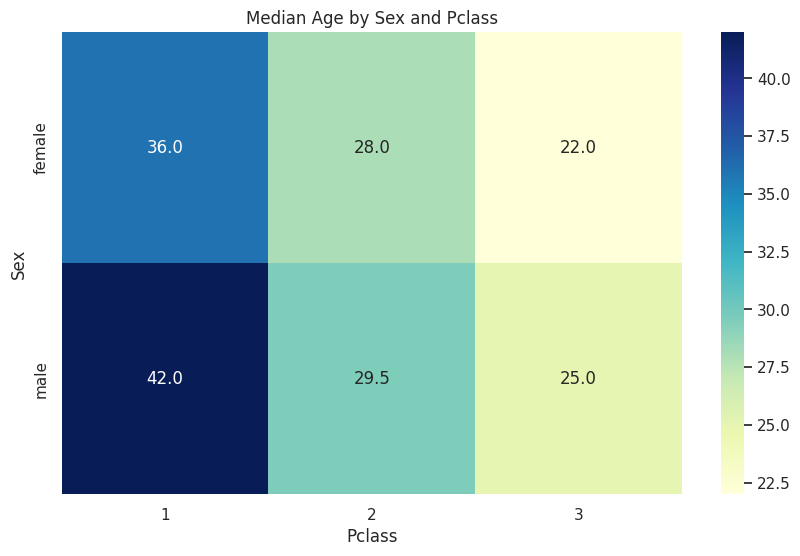

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Reshape the age_by_pclass_sex Series to a DataFrame for heatmap plotting
median_age_df = age_by_pclass_sex.unstack()

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(median_age_df, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title('Median Age by Sex and Pclass')
plt.xlabel('Pclass')
plt.ylabel('Sex')
plt.show()


### **1.2.2 Embarked**
`Embarked` is a categorical feature and there are only **2** missing values in whole data set. Both of those passengers are female, upper class and they have the same ticket number. This means that they know each other and embarked from the same port together. The mode `Embarked` value for an upper class female passenger is **C (Cherbourg)**, but this doesn't necessarily mean that they embarked from that port.

In [8]:
df_all[df_all['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,39.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
829,25.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


In [9]:
embarked_mapping = {'C': 0, 'Q': 1, 'S':2}
df_all['Embarked'] = df_all['Embarked'].map(embarked_mapping)

In [10]:
# Check if 'Embarked' is encoded numerically
# If not, encode it before calculating the correlation
# Assuming 'Embarked' is already numerically encoded

# Compute correlation between 'Pclass' and 'Embarked'
correlation = df_all['Pclass'].corr(df_all['Embarked'])

print("Correlation between Pclass and Embarked:", correlation)


Correlation between Pclass and Embarked: 0.1873492089061008


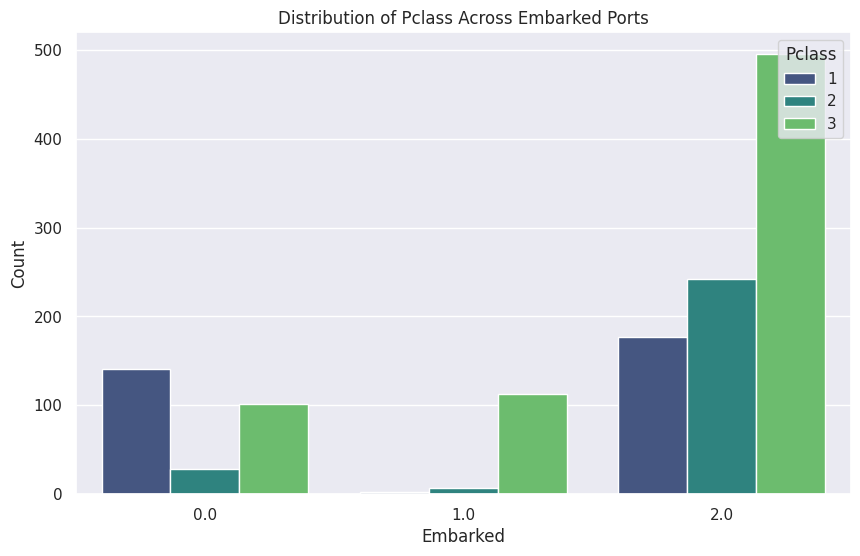

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a grouped bar plot
plt.figure(figsize=(10, 6))
sns.countplot(data=df_all, x='Embarked', hue='Pclass', palette='viridis')
plt.title('Distribution of Pclass Across Embarked Ports')
plt.xlabel('Embarked')
plt.ylabel('Count')
plt.legend(title='Pclass', loc='upper right')
plt.show()


In [12]:
df_all['Embarked']= df_all['Embarked'].fillna('S')

### **1.2.3 Fare**
There is only one passenger with missing `Fare` value. We can assume that `Fare` is related to family size (`Parch` and `SibSp`) and `Pclass` features. Median `Fare` value of a male with a third class ticket and no family is a logical choice to fill the missing value.

There is only one passenger with missing Fare value. We can assume that Fare is related to family size (Parch and SibSp) and Pclass features. Median Fare value of a male with a third class ticket and no family is a logical choice to fill the missing value.

In [13]:
df_all[df_all['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1043,44.0,NaN,2.0,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


In [14]:
est_fare = df_all.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
df_all['Fare'] = df_all['Fare'].fillna(est_fare)

### **1.2.4 Cabin**
`Cabin` feature is little bit tricky and it needs further exploration. The large portion of the `Cabin` feature is missing and the feature itself can't be ignored completely because some the cabins might have higher survival rates. It turns out to be the first letter of the `Cabin` values are the decks in which the cabins are located. Those decks were mainly separated for one passenger class, but some of them were used by multiple passenger classes.
![alt text](https://vignette.wikia.nocookie.net/titanic/images/f/f9/Titanic_side_plan.png/revision/latest?cb=20180322183733)
* On the Boat Deck there were **6** rooms labeled as **T, U, W, X, Y, Z** but only the **T** cabin is present in the dataset
* **A**, **B** and **C** decks were only for 1st class passengers
* **D** and **E** decks were for all classes
* **F** and **G** decks were for both 2nd and 3rd class passengers
* From going **A** to **G**, distance to the staircase increases which might be a factor of survival

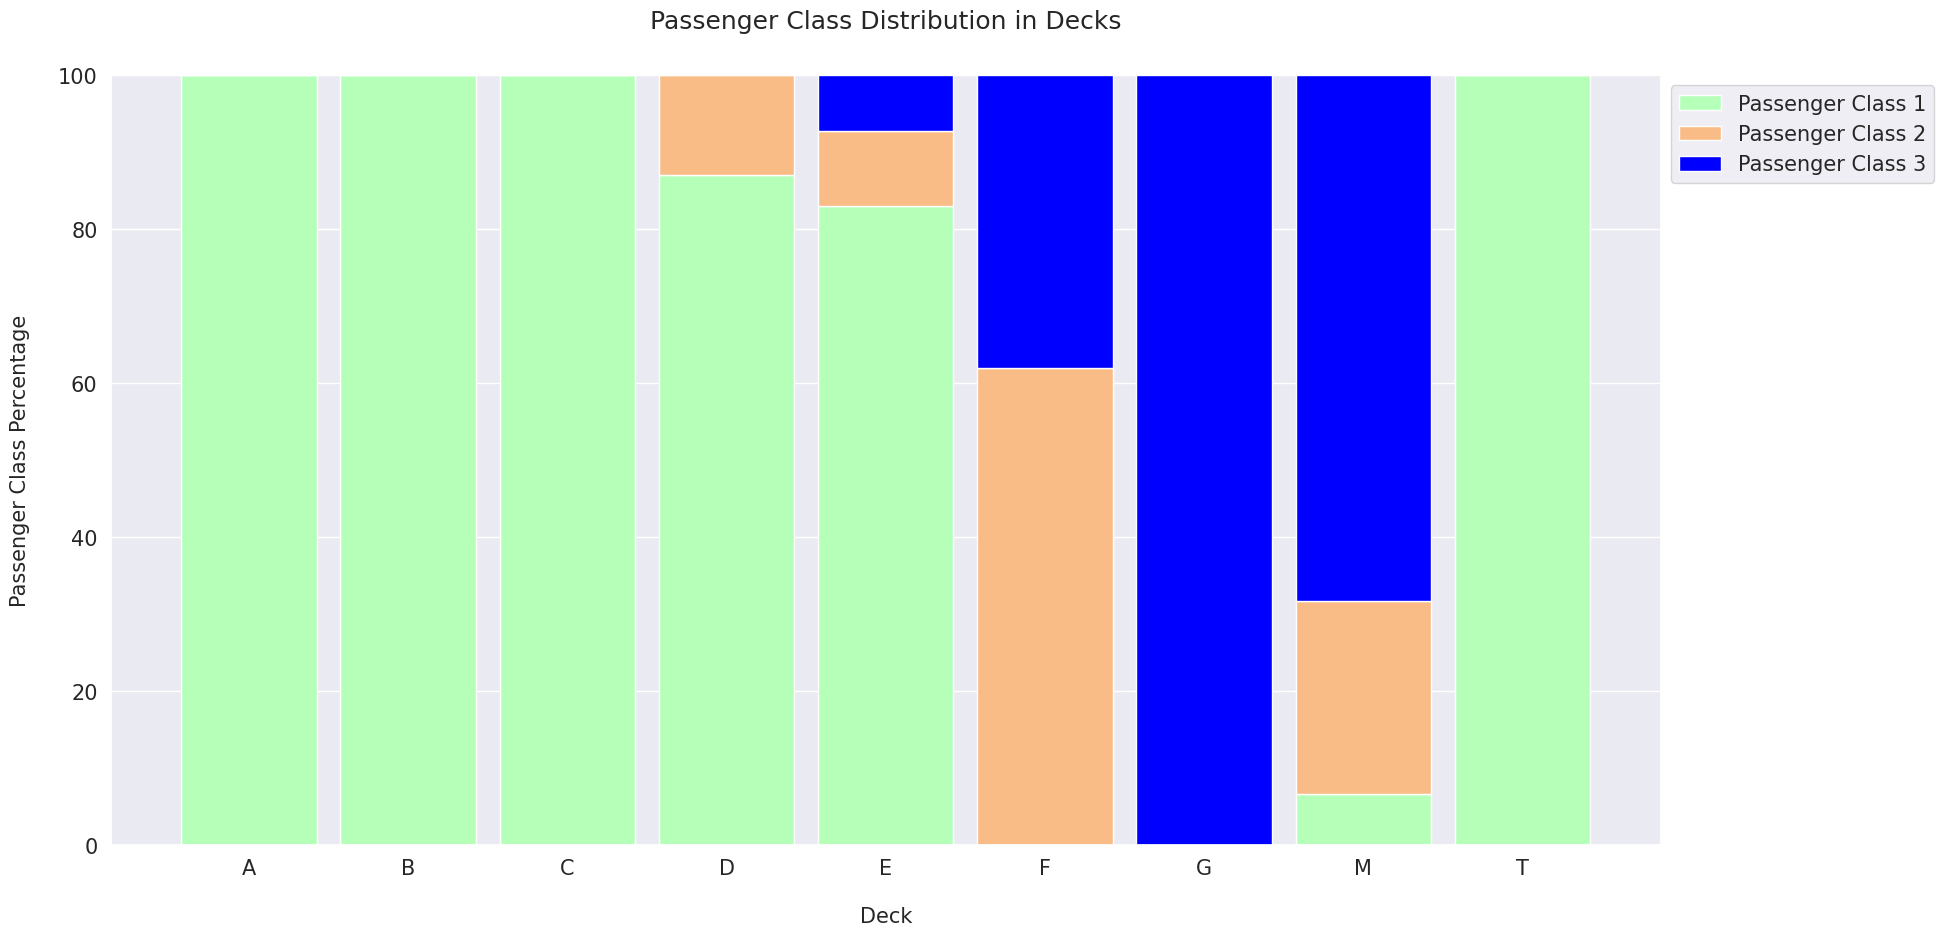

In [15]:
# Creating Deck column from the first letter of the Cabin column (M stands for Missing)
df_all['Deck']= df_all['Cabin'].apply(lambda s : s[0] if pd.notnull(s) else 'M')
# Creating Deck column from the first letter of the Cabin column (M stands for Missing)
df_all['Deck'] = df_all['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

df_all_decks = df_all.groupby(['Deck', 'Pclass']).count().drop(columns=['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 
                                                                        'Fare', 'Embarked', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name': 'Count'}).transpose()

def get_pclass_dist(df):
    
    # Creating a dictionary for every passenger class count in every deck
    deck_counts = {'A': {}, 'B': {}, 'C': {}, 'D': {}, 'E': {}, 'F': {}, 'G': {}, 'M': {}, 'T': {}}
    decks = df.columns.levels[0]    
    
    for deck in decks:
        for pclass in range(1, 4):
            try:
                count = df[deck][pclass][0]
                deck_counts[deck][pclass] = count 
            except KeyError:
                deck_counts[deck][pclass] = 0
                
    df_decks = pd.DataFrame(deck_counts)    
    deck_percentages = {}

    # Creating a dictionary for every passenger class percentage in every deck
    for col in df_decks.columns:
        deck_percentages[col] = [(count / df_decks[col].sum()) * 100 for count in df_decks[col]]
        
    return deck_counts, deck_percentages

def display_pclass_dist(percentages):
    
    df_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M', 'T')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85
    
    pclass1 = df_percentages[0]
    pclass2 = df_percentages[1]
    pclass3 = df_percentages[2]
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, pclass1, color='#b5ffb9', edgecolor='white', width=bar_width, label='Passenger Class 1')
    plt.bar(bar_count, pclass2, bottom=pclass1, color='#f9bc86', edgecolor='white', width=bar_width, label='Passenger Class 2')
    plt.bar(bar_count, pclass3, bottom=pclass1 + pclass2, color='blue', edgecolor='white', width=bar_width, label='Passenger Class 3')

    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Passenger Class Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Passenger Class Distribution in Decks', size=18, y=1.05)   
    
    plt.show()    

all_deck_count, all_deck_per = get_pclass_dist(df_all_decks)
display_pclass_dist(all_deck_per)

As I suspected, every deck has different survival rates and that information can't be discarded. Deck **B**, **C**, **D** and **E** have the highest survival rates. Those decks are mostly occupied by 1st class passengers. **M** has the lowest survival rate which is mostly occupied by 2nd and 3rd class passengers. To conclude, cabins used by 1st class passengers have higher survival rates than cabins used by 2nd and 3rd class passengers. In my opinion **M** (Missing `Cabin` values) has the lowest survival rate because they couldn't retrieve the cabin data of the victims. That's why I believe labeling that group as **M** is a reasonable way to handle the missing data. It is a unique group with shared characteristics. `Deck` feature has high-cardinality right now so some of the values are grouped with each other based on their similarities.
* **A**, **B** and **C** decks are labeled as **ABC** because all of them have only 1st class passengers
* **D** and **E** decks are labeled as **DE** because both of them have similar passenger class distribution and same survival rate
* **F** and **G** decks are labeled as **FG** because of the same reason above
* **M** deck doesn't need to be grouped with other decks because it is very different from others and has the lowest survival rate.

In [16]:
# Passenger in the T deck is changed to A
idx = df_all[df_all['Deck'] == 'T'].index
df_all.loc[idx, 'Deck'] = 'A'

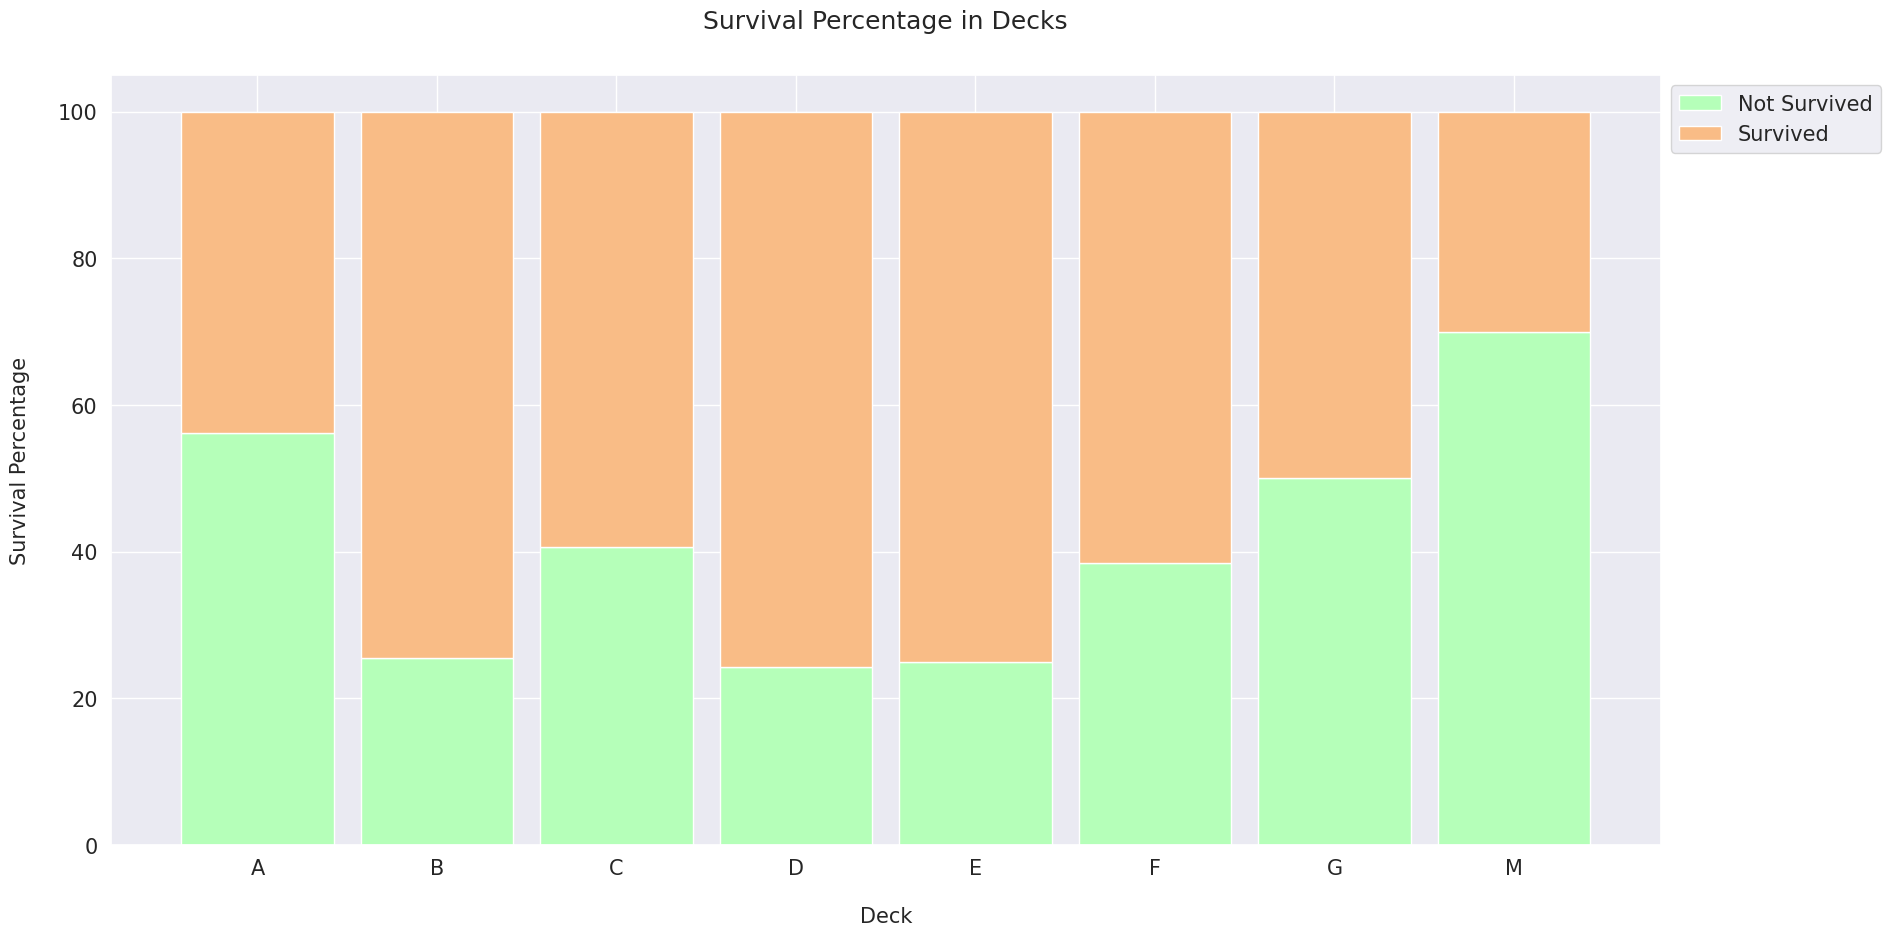

In [17]:
df_all_decks_survived = df_all.groupby(['Deck', 'Survived']).count().drop(columns=['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 
                                                                                   'Embarked', 'Pclass', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name':'Count'}).transpose()

def get_survived_dist(df):
    
    # Creating a dictionary for every survival count in every deck
    surv_counts = {'A':{}, 'B':{}, 'C':{}, 'D':{}, 'E':{}, 'F':{}, 'G':{}, 'M':{}}
    decks = df.columns.levels[0]    

    for deck in decks:
        for survive in range(0, 2):
            surv_counts[deck][survive] = df[deck][survive][0]
            
    df_surv = pd.DataFrame(surv_counts)
    surv_percentages = {}

    for col in df_surv.columns:
        surv_percentages[col] = [(count / df_surv[col].sum()) * 100 for count in df_surv[col]]
        
    return surv_counts, surv_percentages

def display_surv_dist(percentages):
    
    df_survived_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85    

    not_survived = df_survived_percentages[0]
    survived = df_survived_percentages[1]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, not_survived, color='#b5ffb9', edgecolor='white', width=bar_width, label="Not Survived")
    plt.bar(bar_count, survived, bottom=not_survived, color='#f9bc86', edgecolor='white', width=bar_width, label="Survived")
 
    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Survival Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Survival Percentage in Decks', size=18, y=1.05)
    
    plt.show()

all_surv_count, all_surv_per = get_survived_dist(df_all_decks_survived)
display_surv_dist(all_surv_per)

In [18]:
df_all['Deck'] = df_all['Deck'].replace(['A', 'B', 'C'], 'ABC')
df_all['Deck'] = df_all['Deck'].replace(['D','E'], 'DE')
df_all['Deck'] = df_all['Deck'].replace(['F', 'G'], 'FG')

df_all['Deck'].value_counts()

Deck
M      1014
ABC     182
DE       87
FG       26
Name: count, dtype: int64

In [19]:


#Define a function DISPLAY MISSING:
def display_missing(df):
    missing = df.isnull().sum()
  
    print(missing)


df_train, df_test = divide_df(df_all)
dfs = [df_train, df_test]

for df in dfs:
    display_missing(df)

Age              0
Cabin          687
Embarked         0
Fare             0
Name             0
Parch            0
PassengerId      0
Pclass           0
Sex              0
SibSp            0
Survived         0
Ticket           0
Deck             0
dtype: int64
Age              0
Cabin          327
Embarked         0
Fare             0
Name             0
Parch            0
PassengerId      0
Pclass           0
Sex              0
SibSp            0
Ticket           0
Deck             0
dtype: int64


After filling the missing values in `Age`, `Embarked`, `Fare` and `Deck` features, there is no missing value left in both training and test set. `Cabin` is dropped because `Deck` feature is used instead of it.

In [20]:
# Dropping the Cabin feature
df_all.drop(['Cabin'], inplace=True, axis=1)

df_train, df_test = divide_df(df_all)
dfs = [df_train, df_test]

for df in dfs:
    display_missing(df)

Age            0
Embarked       0
Fare           0
Name           0
Parch          0
PassengerId    0
Pclass         0
Sex            0
SibSp          0
Survived       0
Ticket         0
Deck           0
dtype: int64
Age            0
Embarked       0
Fare           0
Name           0
Parch          0
PassengerId    0
Pclass         0
Sex            0
SibSp          0
Ticket         0
Deck           0
dtype: int64


### **1.3 Target Distribution**
* **38.38%** (342/891) of training set is **Class 1**
* **61.62%** (549/891) of training set is **Class 0**

342 of 891 passengers survived and it is the 38.38% of the training set.
549 of 891 passengers didnt survive and it is the 61.62% of the training set.


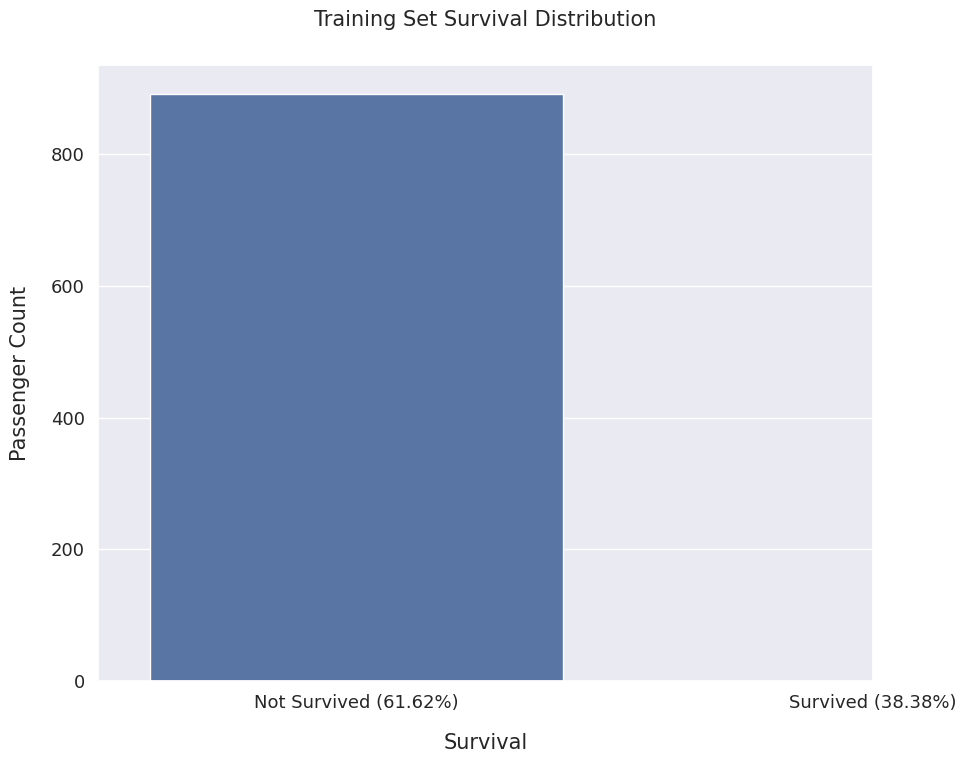

In [21]:
survived = df_train['Survived'].value_counts()[1]
not_survived = df_train['Survived'].value_counts()[0]
survived_per = survived / df_train.shape[0] * 100
not_survived_per = not_survived / df_train.shape[0] * 100

print('{} of {} passengers survived and it is the {:.2f}% of the training set.'.format(survived, df_train.shape[0], survived_per))
print('{} of {} passengers didnt survive and it is the {:.2f}% of the training set.'.format(not_survived, df_train.shape[0], not_survived_per))

plt.figure(figsize=(10, 8))
sns.countplot(df_train['Survived'])

plt.xlabel('Survival', size=15, labelpad=15)
plt.ylabel('Passenger Count', size=15, labelpad=15)
plt.xticks((0, 1), ['Not Survived ({0:.2f}%)'.format(not_survived_per), 'Survived ({0:.2f}%)'.format(survived_per)])
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)

plt.title('Training Set Survival Distribution', size=15, y=1.05)

plt.show()

### **1.4 Correlations**
Features are highly correlated with each other and dependent to each other. The highest correlation between features is **0.549500** in training set and **0.577147** in test set (between `Fare` and `Pclass`). The other features are also highly correlated. There are **9** correlations in training set and **6** correlations in test set that are higher than **0.1**.

In [22]:
numeric_columns = df_train.select_dtypes(include=['int64', 'float64']).columns
df_test_corr = df_train[numeric_columns].corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_test_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_test_corr.drop(df_test_corr[df_test_corr['Correlation Coefficient'] == 1.0].index, inplace=True)




In [23]:
numeric_columns = df_test.select_dtypes(include=['int64', 'float64']).columns
df_test_corr = df_test[numeric_columns].corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_test_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_test_corr.drop(df_test_corr[df_test_corr['Correlation Coefficient'] == 1.0].index, inplace=True)


# Higher Correlations in Testing set
corr = df_test_corr['Correlation Coefficient'] > 0.1

df_filter = df_test_corr[corr]

df_filter.drop_duplicates(subset=['Correlation Coefficient'], inplace =True)
print(df_filter)

   Feature 1 Feature 2  Correlation Coefficient
6       Fare    Pclass                 0.577489
8      Parch     SibSp                 0.306895
10      Fare     Parch                 0.230410
12      Fare     SibSp                 0.172032


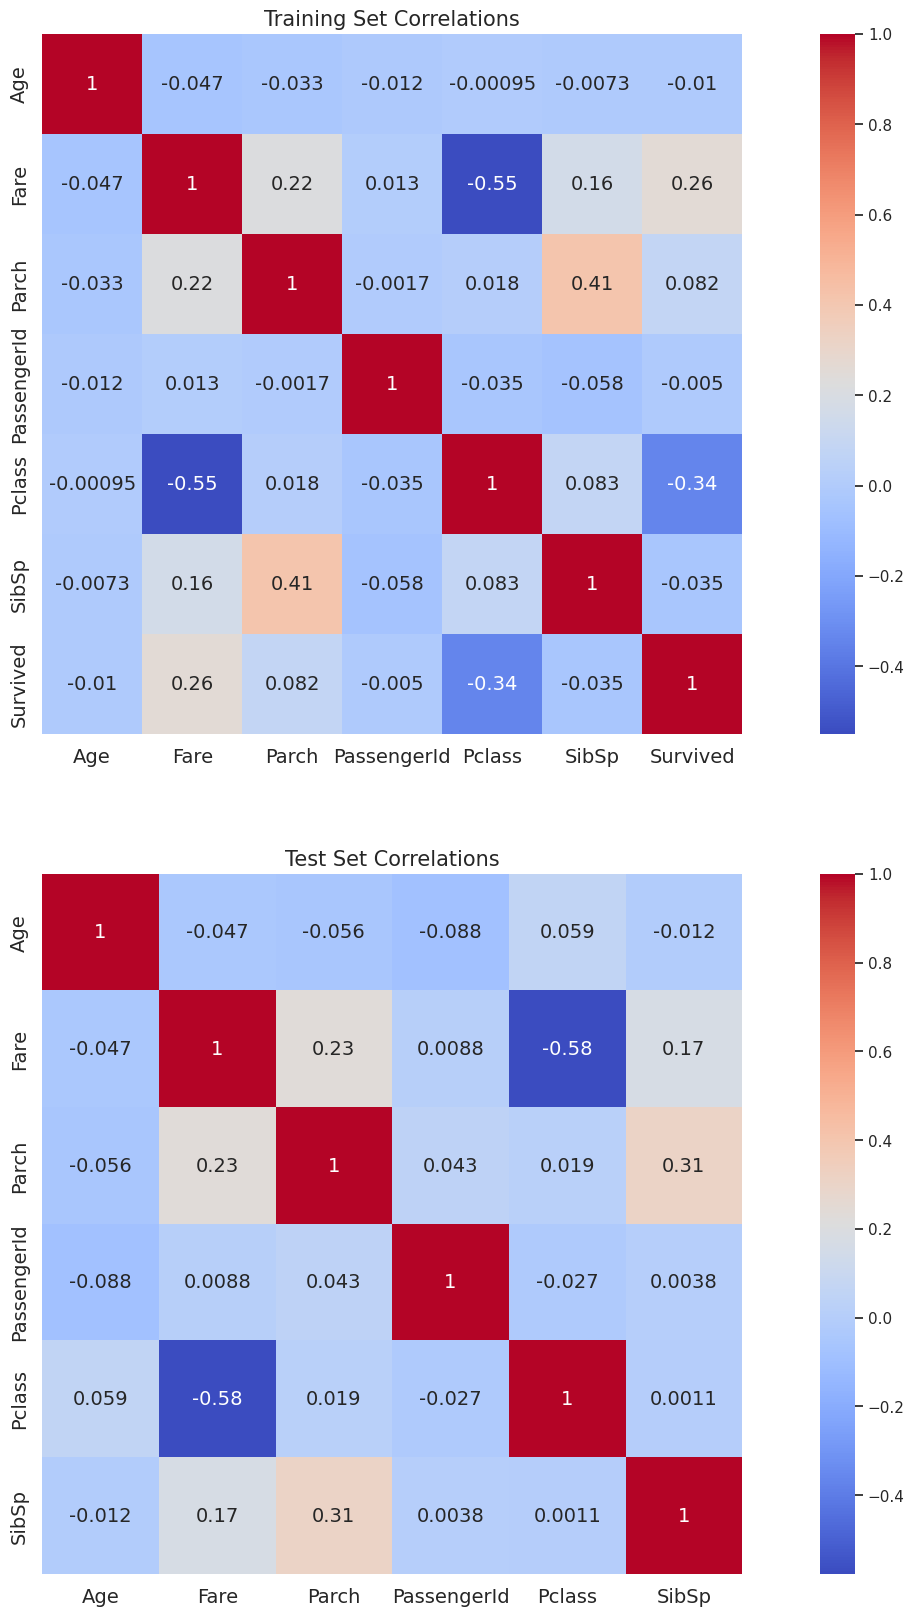

In [24]:
# Select only numeric columns in the DataFrame
numeric_columns_train = df_train.select_dtypes(include=['int64', 'float64'])
numeric_columns_test = df_test.select_dtypes(include=['int64', 'float64'])

# Create subplots
fig, axs = plt.subplots(nrows=2, figsize=(20, 20))

# Plot heatmap for training set correlations
sns.heatmap(numeric_columns_train.corr(), ax=axs[0], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})

# Plot heatmap for test set correlations
sns.heatmap(numeric_columns_test.corr(), ax=axs[1], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})

# Customize tick labels and set titles for subplots
for i in range(2):    
    axs[i].tick_params(axis='x', labelsize=14)
    axs[i].tick_params(axis='y', labelsize=14)
    axs[i].set_title('Training Set Correlations' if i == 0 else 'Test Set Correlations', size=15)

# Display the figure
plt.show()


### **1.5 Target Distribution in Features**


#### **1.5.1 Continuous Features**
Both of the continuous features (`Age` and `Fare`) have good split points and spikes for a decision tree to learn. One potential problem for both features is, the distribution has more spikes and bumps in training set, but it is smoother in test set. Model may not be able to generalize to test set because of this reason.

* Distribution of `Age` feature clearly shows that children younger than 15 has a higher survival rate than any of the other age groups
* In distribution of `Fare` feature, the survival rate is higher on distribution tails. The distribution also has positive skew because of the extremely large outliers

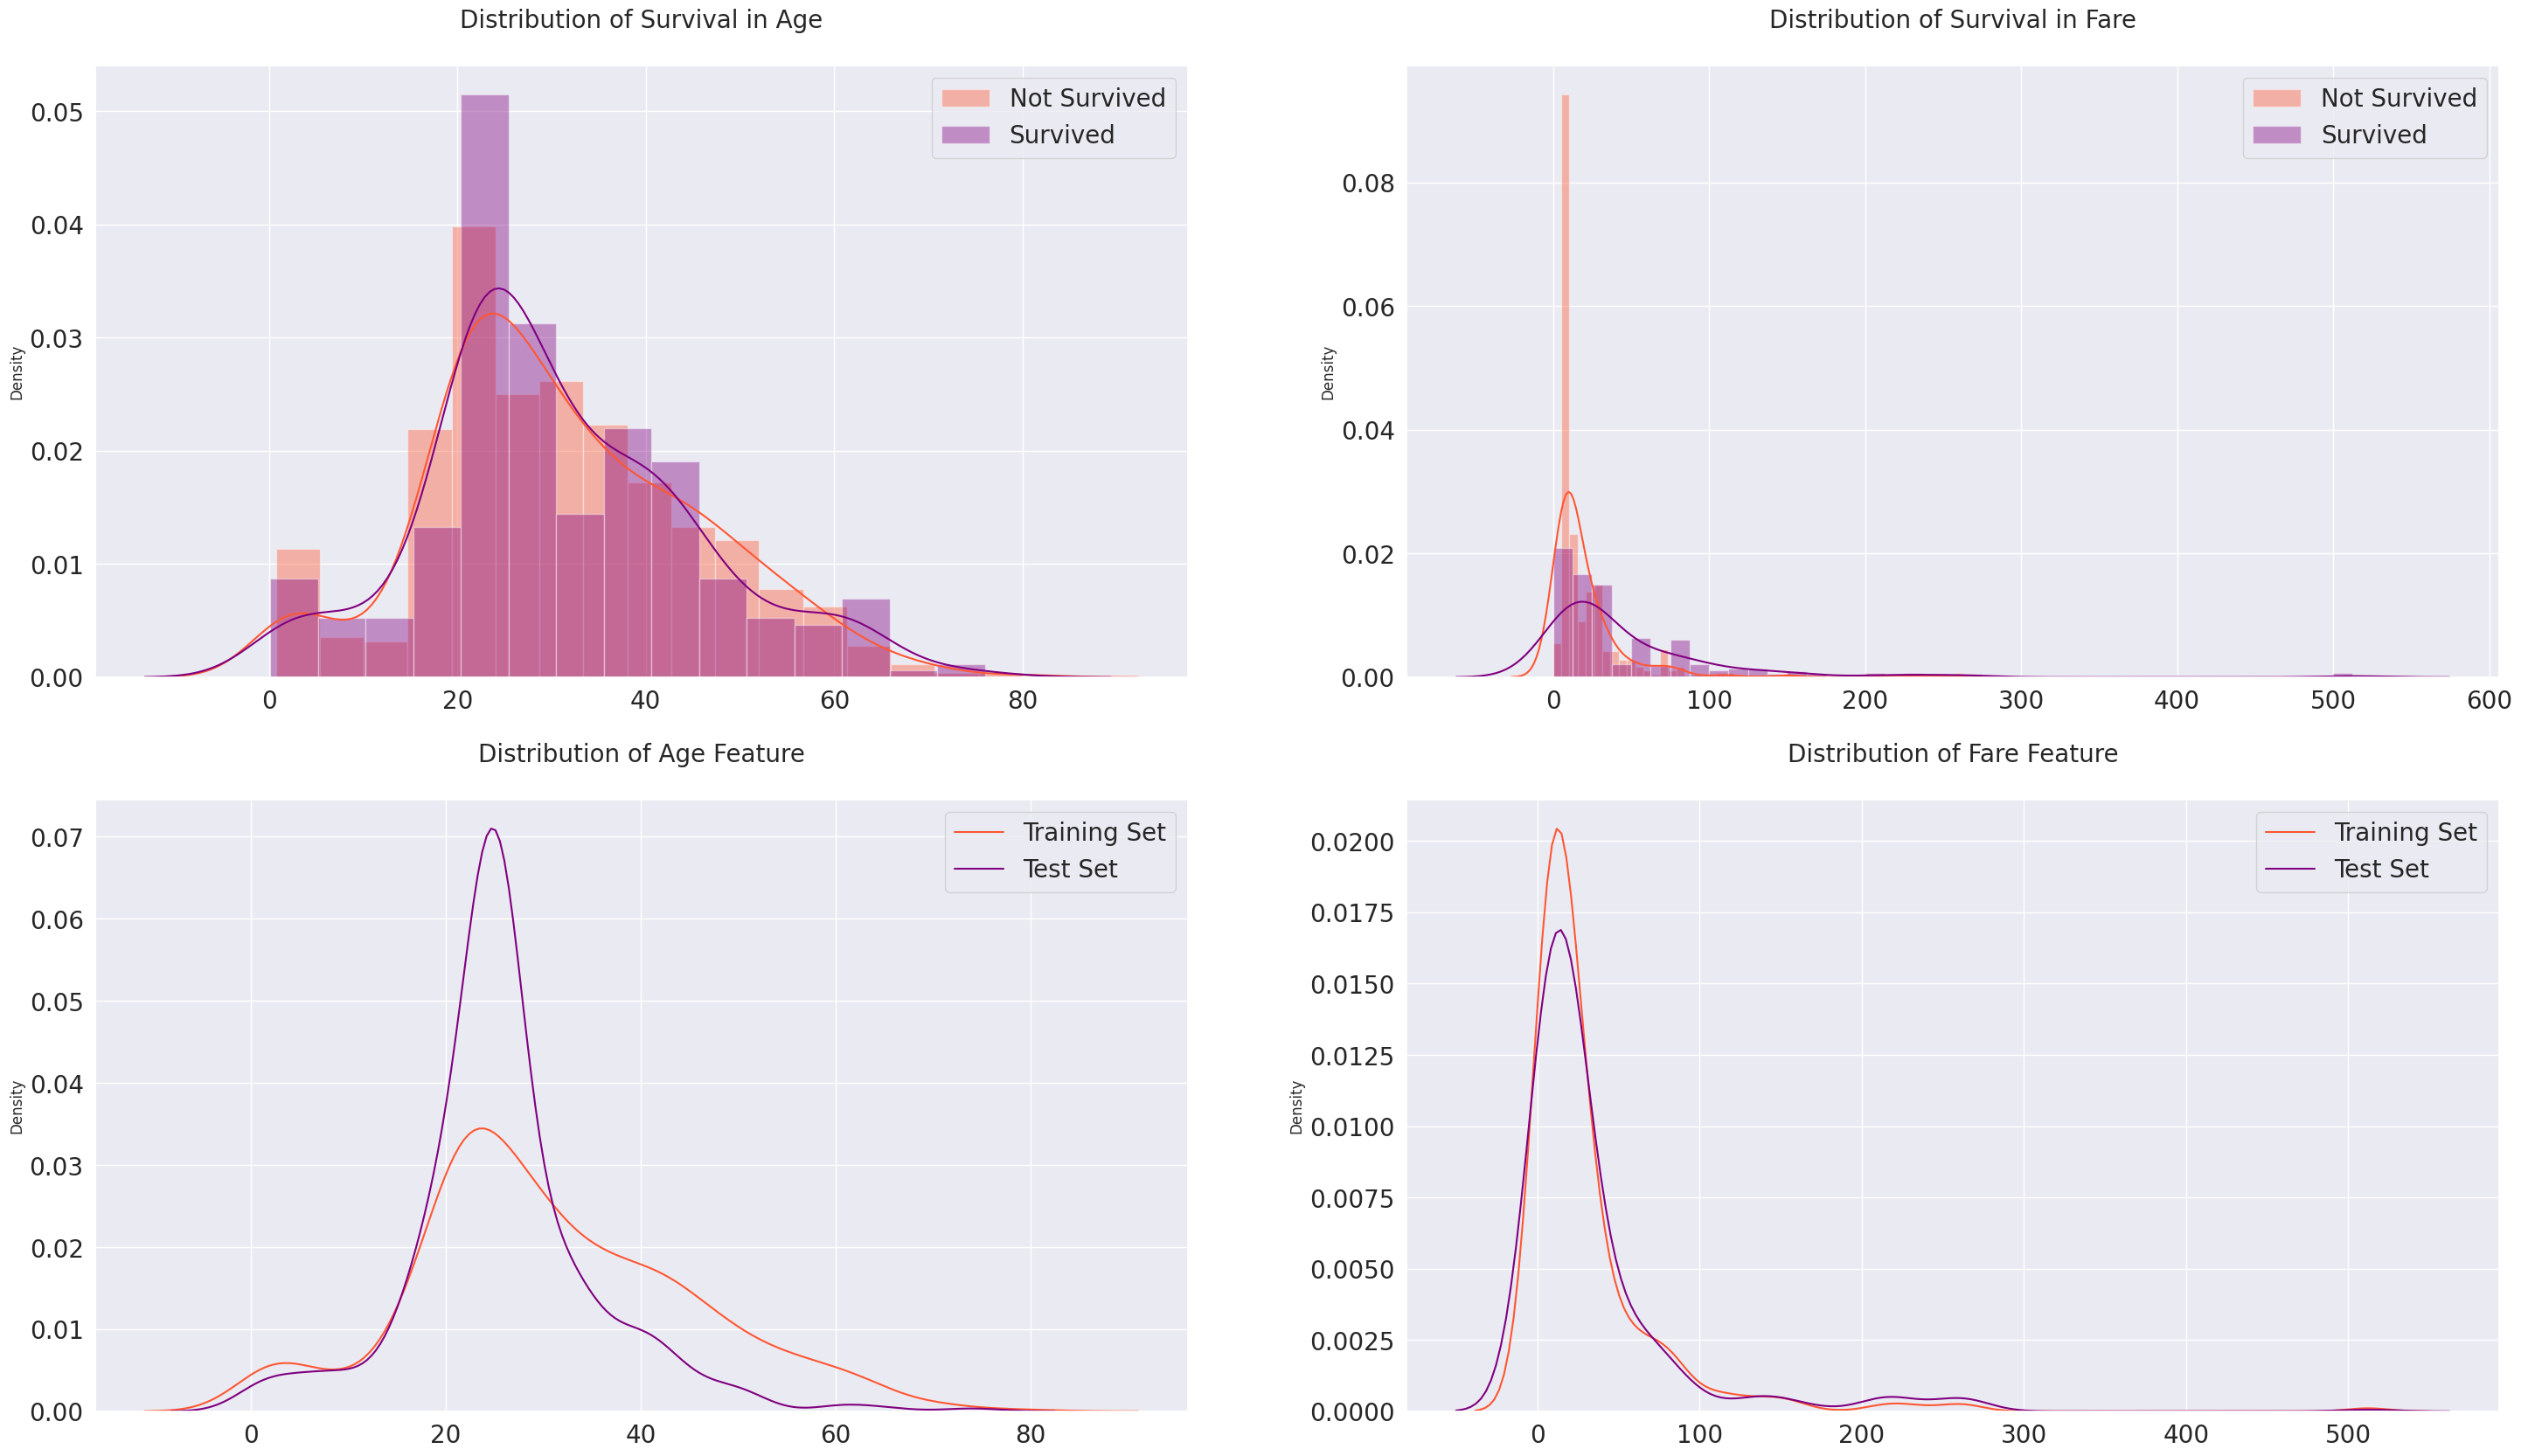

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

cont_features = ['Age', 'Fare']
surv = df_train['Survived'] == 1

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 20))
plt.subplots_adjust(right=1.5)

for i, feature in enumerate(cont_features):    
    # Distribution of survival in feature
    sns.distplot(df_train[~surv][feature], label='Not Survived', hist=True, color='#FF5733', ax=axs[0][i])
    sns.distplot(df_train[surv][feature], label='Survived', hist=True, color='#800080', ax=axs[0][i])
    
    # Distribution of feature in dataset
    sns.distplot(df_train[feature], label='Training Set', hist=False, color='#FF5733', ax=axs[1][i])
    sns.distplot(df_test[feature], label='Test Set', hist=False, color='#800080', ax=axs[1][i])
    
    axs[0][i].set_xlabel('')
    axs[1][i].set_xlabel('')
    
    for j in range(2):        
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
    
    axs[0][i].legend(loc='upper right', prop={'size': 20})
    axs[1][i].legend(loc='upper right', prop={'size': 20})
    axs[0][i].set_title('Distribution of Survival in {}'.format(feature), size=20, y=1.05)

axs[1][0].set_title('Distribution of {} Feature'.format('Age'), size=20, y=1.05)
axs[1][1].set_title('Distribution of {} Feature'.format('Fare'), size=20, y=1.05)
        
plt.show()


#### **1.5.2 Categorical Features**
Every categorical feature has at least one class with high mortality rate. Those classes are very helpful to predict whether the passenger is a survivor or victim. Best categorical features are `Pclass` and `Sex` because they have the most homogenous distributions.

* Passengers boarded from **Southampton** has a lower survival rate unlike other ports. More than half of the passengers boarded from **Cherbourg** had survived. This observation could be related to `Pclass` feature
* `Parch` and `SibSp` features show that passengers with only one family member has a higher survival rate

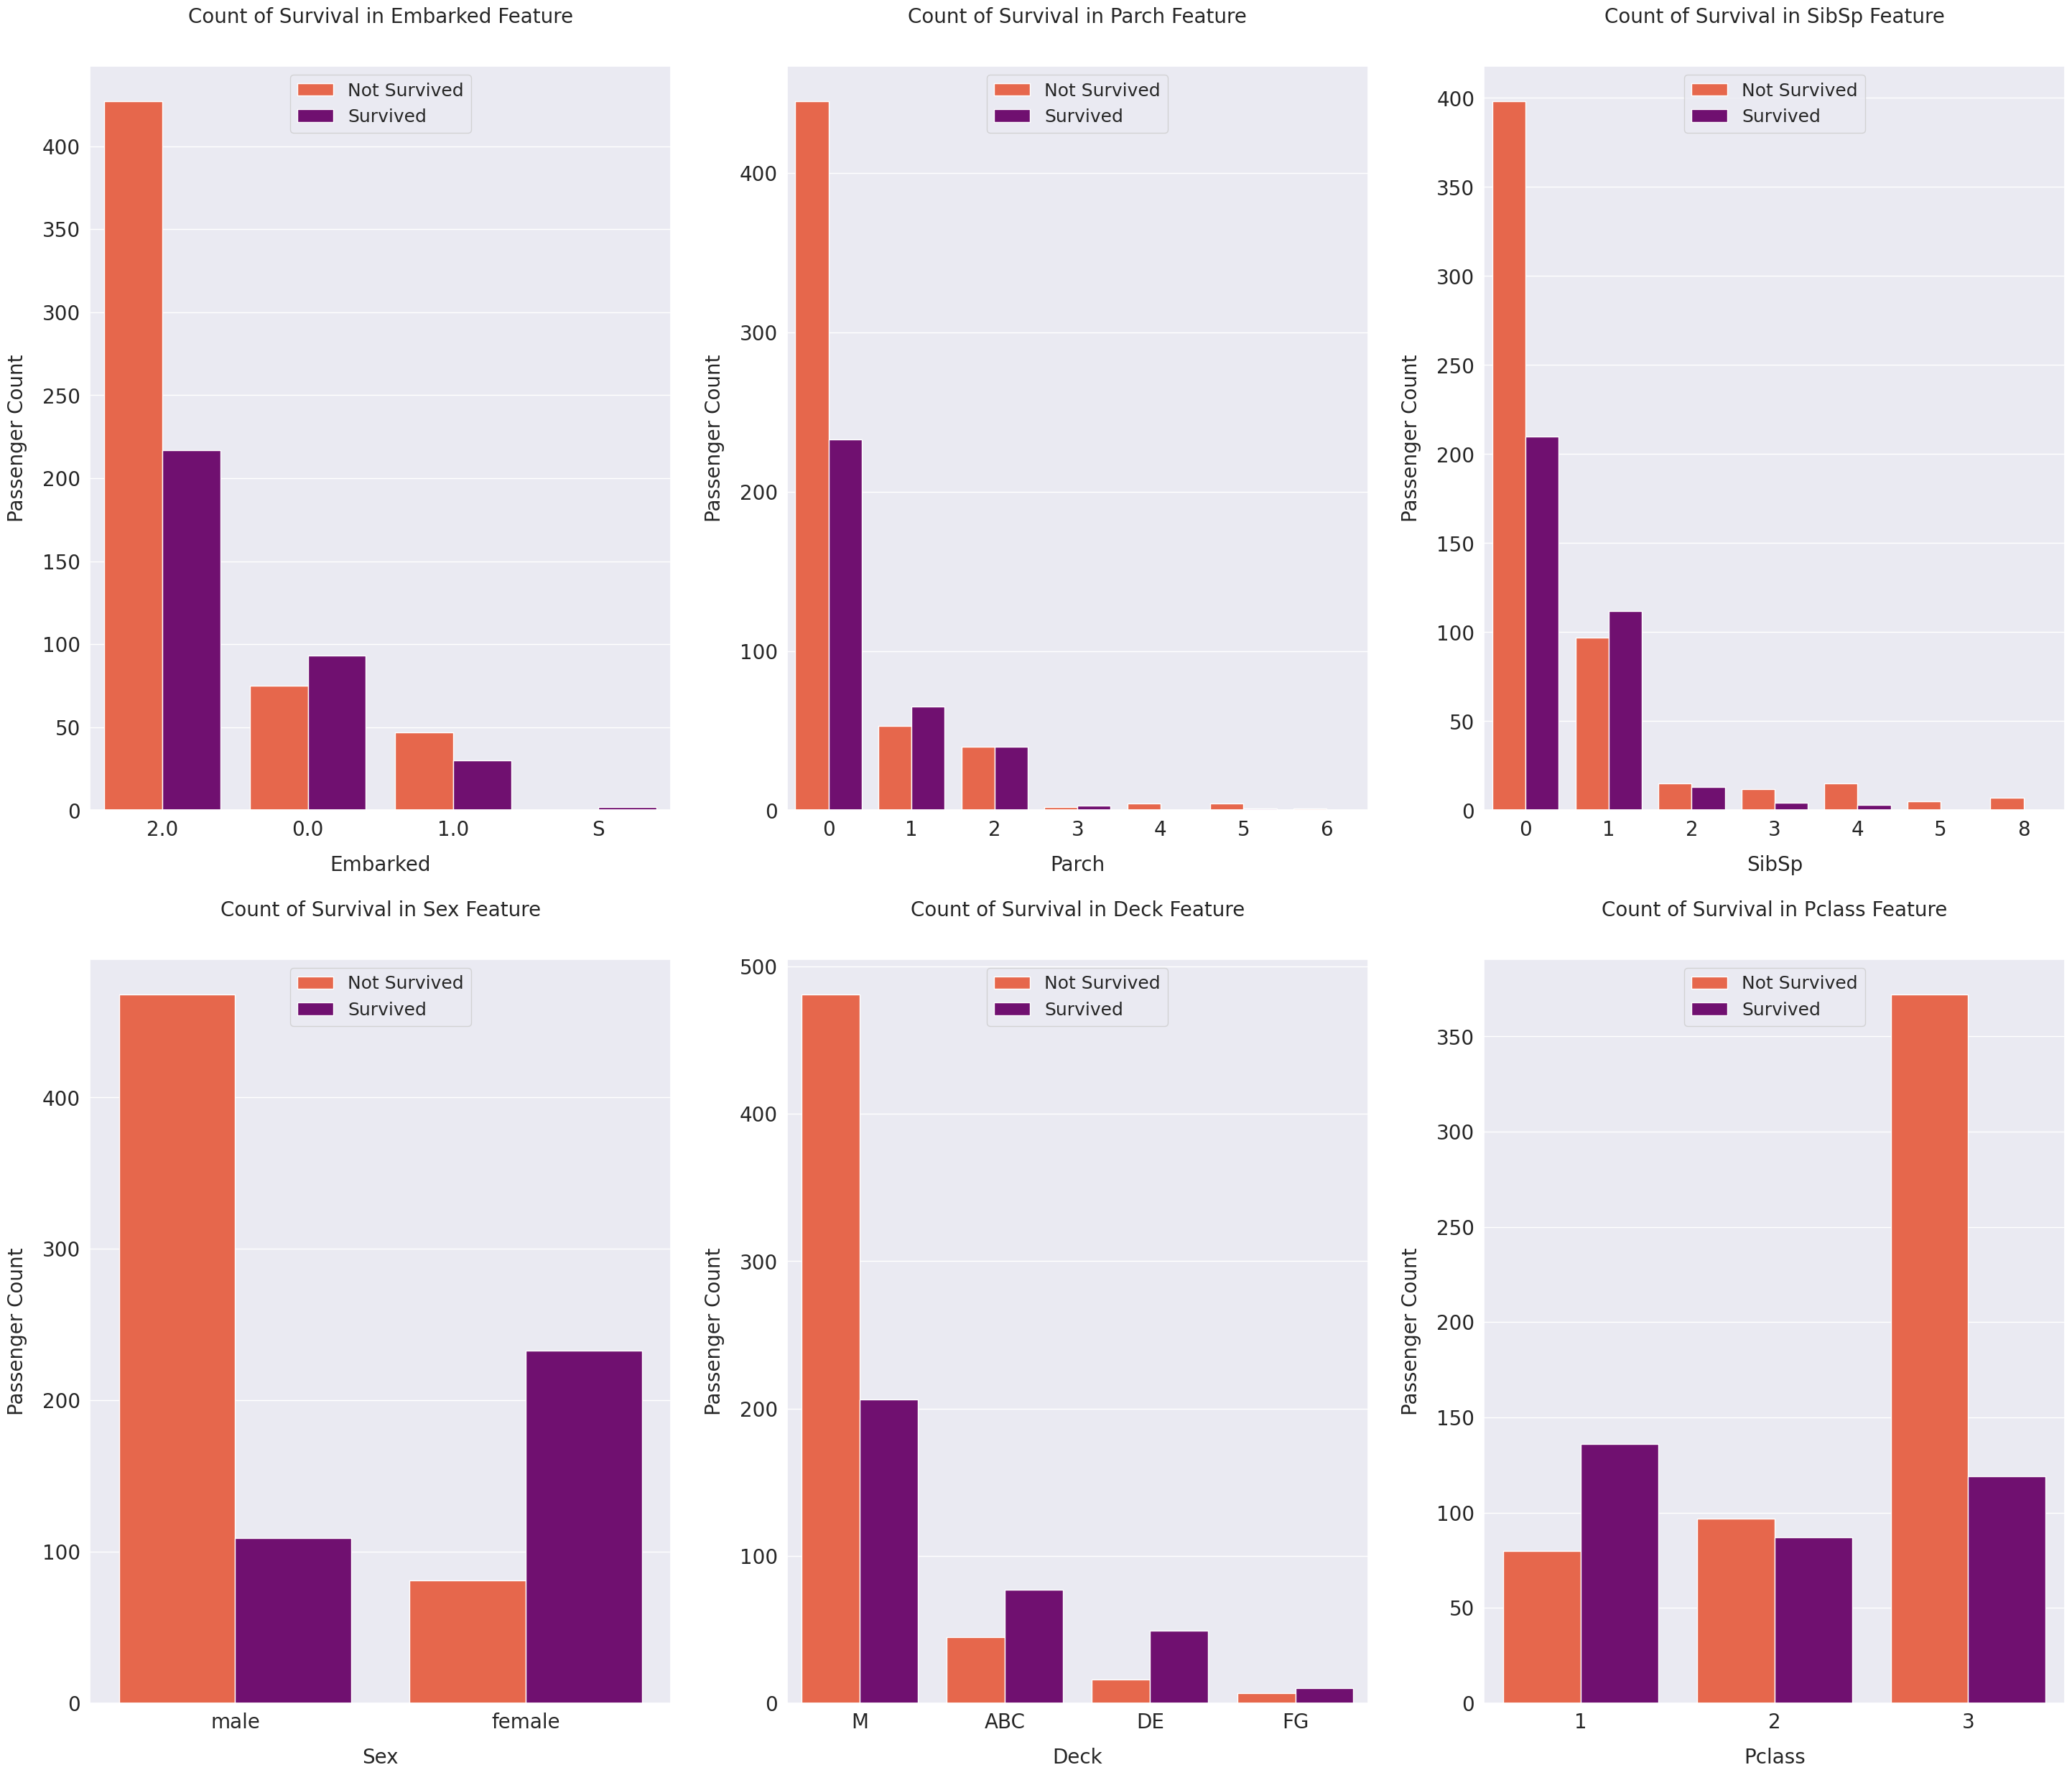

In [26]:
cat_features = ['Embarked', 'Parch', 'SibSp', 'Sex', 'Deck', 'Pclass']

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(20, 20))
plt.subplots_adjust(right=1.5, top=1.25)

for i, feature in enumerate(cat_features, 1):    
    plt.subplot(2, 3, i)
    sns.countplot(x=feature, hue='Survived', data=df_train, palette=['#FF5733', '#800080'])
    
    plt.xlabel('{}'.format(feature), size=20, labelpad=15)
    plt.ylabel('Passenger Count', size=20, labelpad=15)    
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    
    plt.legend(['Not Survived', 'Survived'], loc='upper center', prop={'size': 18})
    plt.title('Count of Survival in {} Feature'.format(feature), size=20, y=1.05)

plt.show()


### **1.6 Conclusion**
Most of the features are correlated with each other. This relationship can be used to create new features with feature transformation and feature interaction. Target encoding could be very useful as well because of the high correlations with `Survived` feature.

Split points and spikes are visible in continuous features. They can be captured easily with a decision tree model, but linear models may not be able to spot them.

Categorical features have very distinct distributions with different survival rates. Those features can be one-hot encoded. Some of those features may be combined with each other to make new features.

Created a new feature called `Deck` and dropped `Cabin` feature at the **Exploratory Data Analysis** part.

# **2. Feature Engineering**

### **2.1 Binning Continuous Features**

#### **2.1.1 Fare**
`Fare` feature is positively skewed and survival rate is extremely high on the right end. **13** quantile based bins are used for `Fare` feature. Even though the bins are too much, they provide decent amount of information gain. The groups at the left side of the graph has the lowest survival rate and the groups at the right side of the graph has the highest survival rate. This high survival rate was not visible in the distribution graph. There is also an unusual group **(15.742, 23.25]** in the middle with high survival rate that is captured in this process.

In [27]:

df_all['Fare'] = pd.qcut(df_all['Fare'], 13)


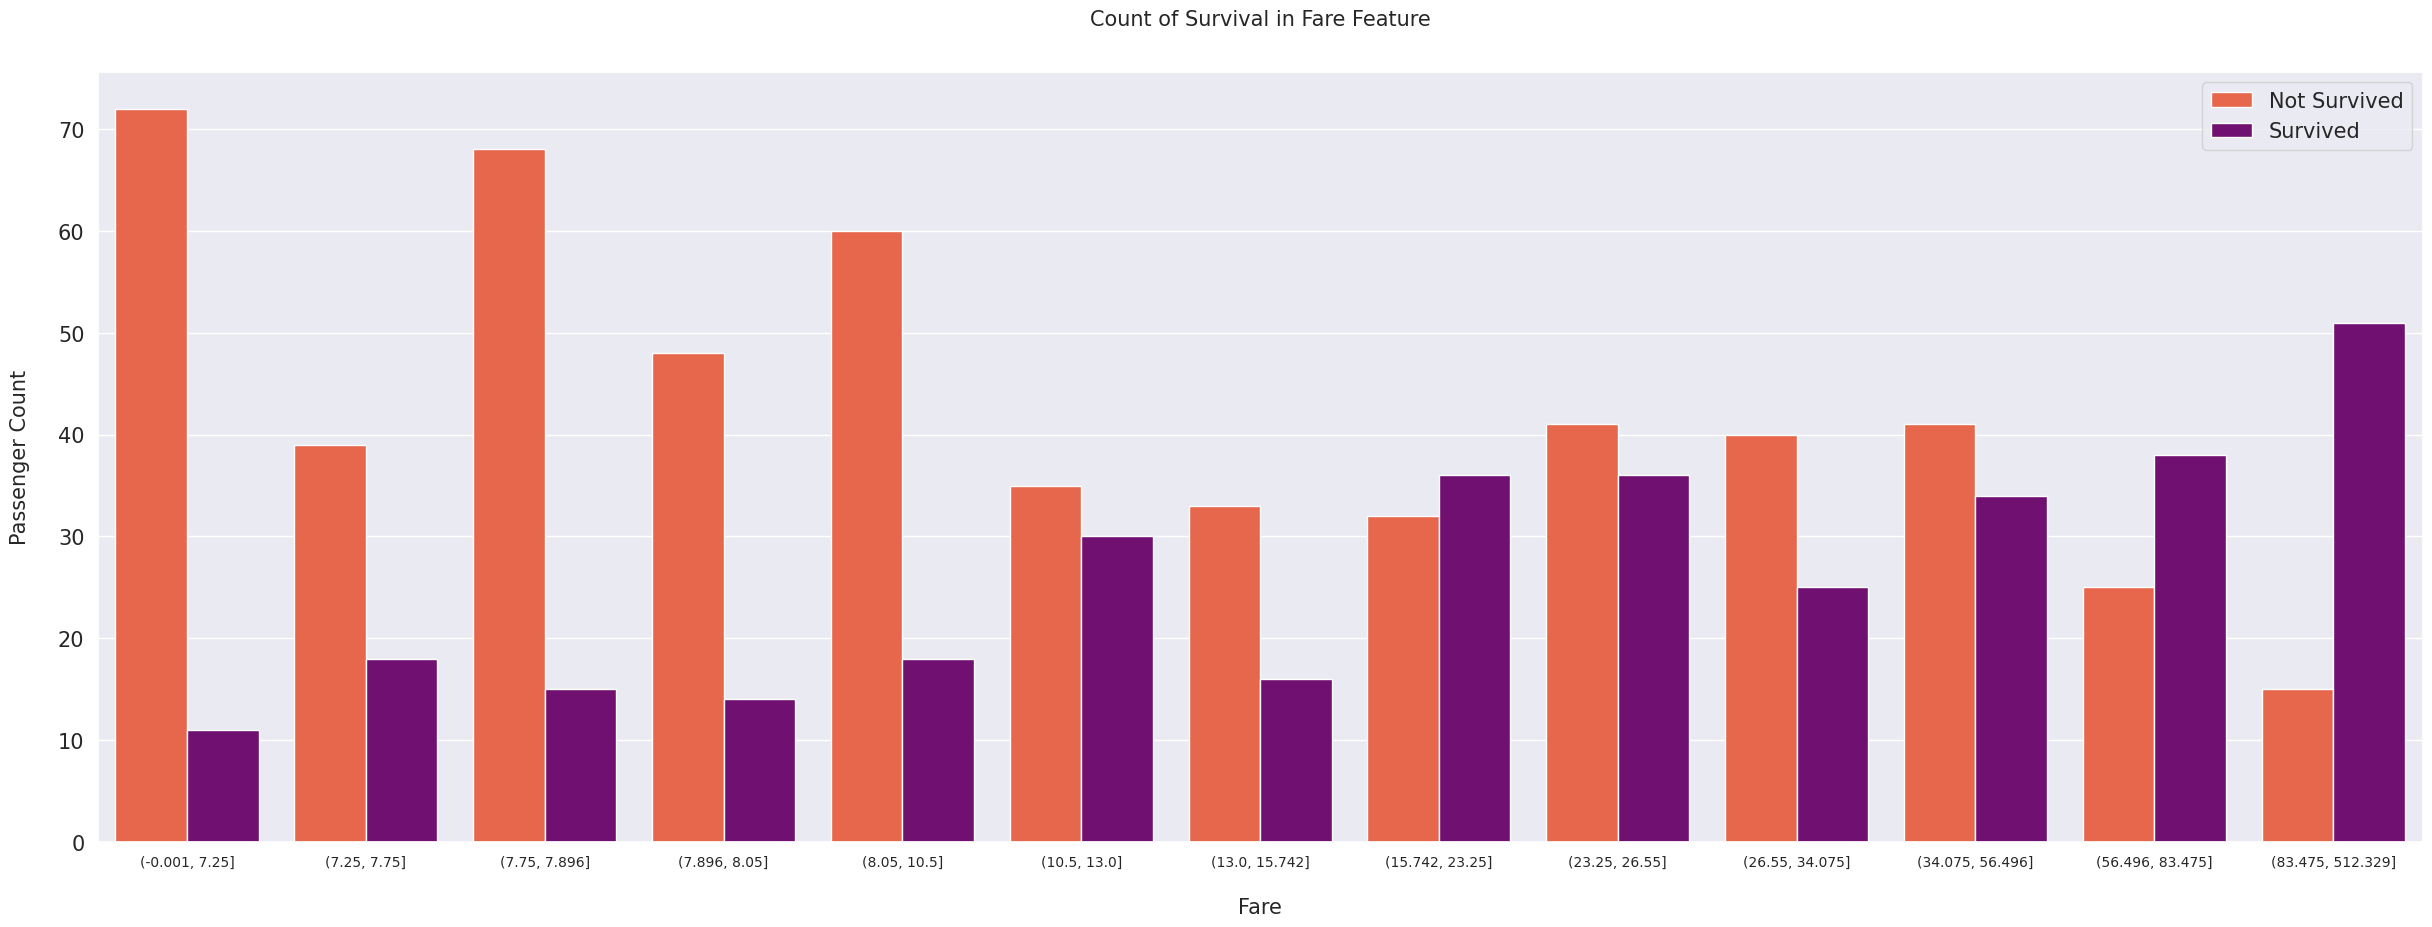

In [28]:
fig, axs = plt.subplots(figsize= (30, 10))
sns.countplot(x='Fare', hue='Survived', data=df_all, palette=['#FF5733', 'purple'])
plt.xlabel('Fare', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Fare'), size=15, y=1.05)

plt.show()

#### **2.1.2 Age**
`Age` feature has a normal distribution with some spikes and bumps and **10** quantile based bins are used for `Age`. The first bin has the highest survival rate and 4th bin has the lowest survival rate. Those were the biggest spikes in the distribution. There is also an unusual group **(34.0, 40.0]** with high survival rate that is captured in this process.

In [29]:
df_all['Age'] = pd.qcut(df_all['Age'], 10)

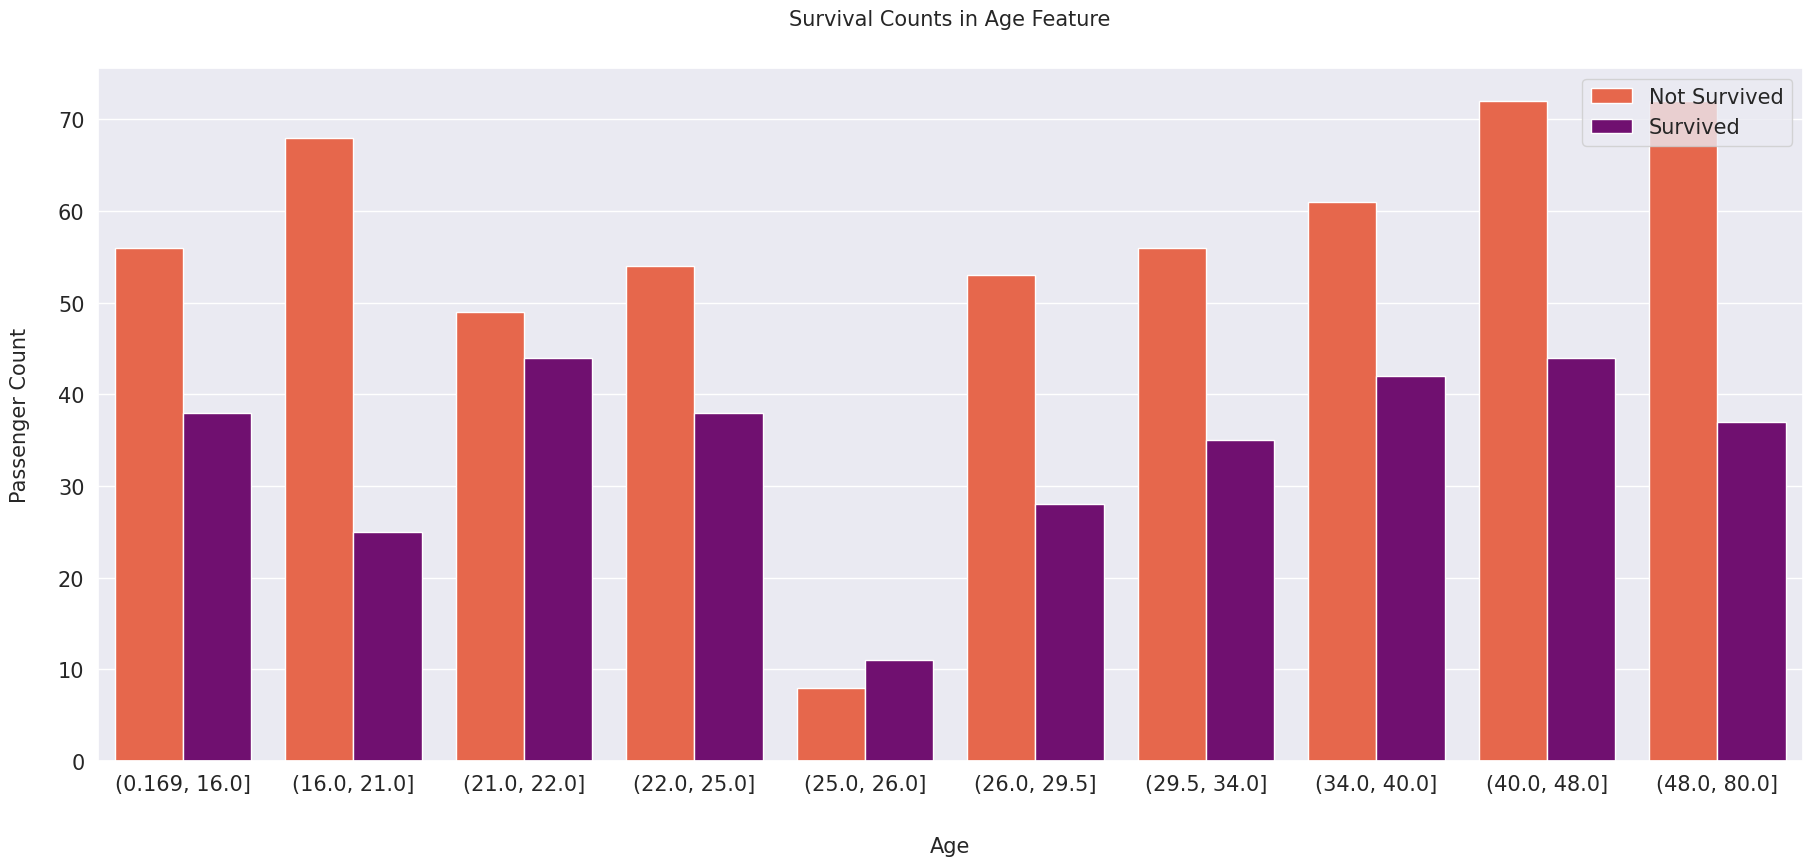

In [30]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Age', hue='Survived', data=df_all, palette=['#FF5733', 'purple'])

plt.xlabel('Age', size=15, labelpad=30)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Survival Counts in {} Feature'.format('Age'), size=15, y=1.05)

plt.show()

### **2.2 Frequency Encoding**
`Family_size` is created by adding `SibSp`, `Parch` and **1**. `SibSp` is the count of siblings and spouse, and `Parch` is the count of parents and children. Those columns are added in order to find the total size of families. Adding **1** at the end, is the current passenger. Graphs have clearly shown that family size is a predictor of survival because different values have different survival rates.
* Family Size with **1** are labeled as **Alone**
* Family Size with **2**, **3** and **4** are labeled as **Small**
* Family Size with **5** and **6** are labeled as **Medium**
* Family Size with **7**, **8** and **11** are labeled as **Large**

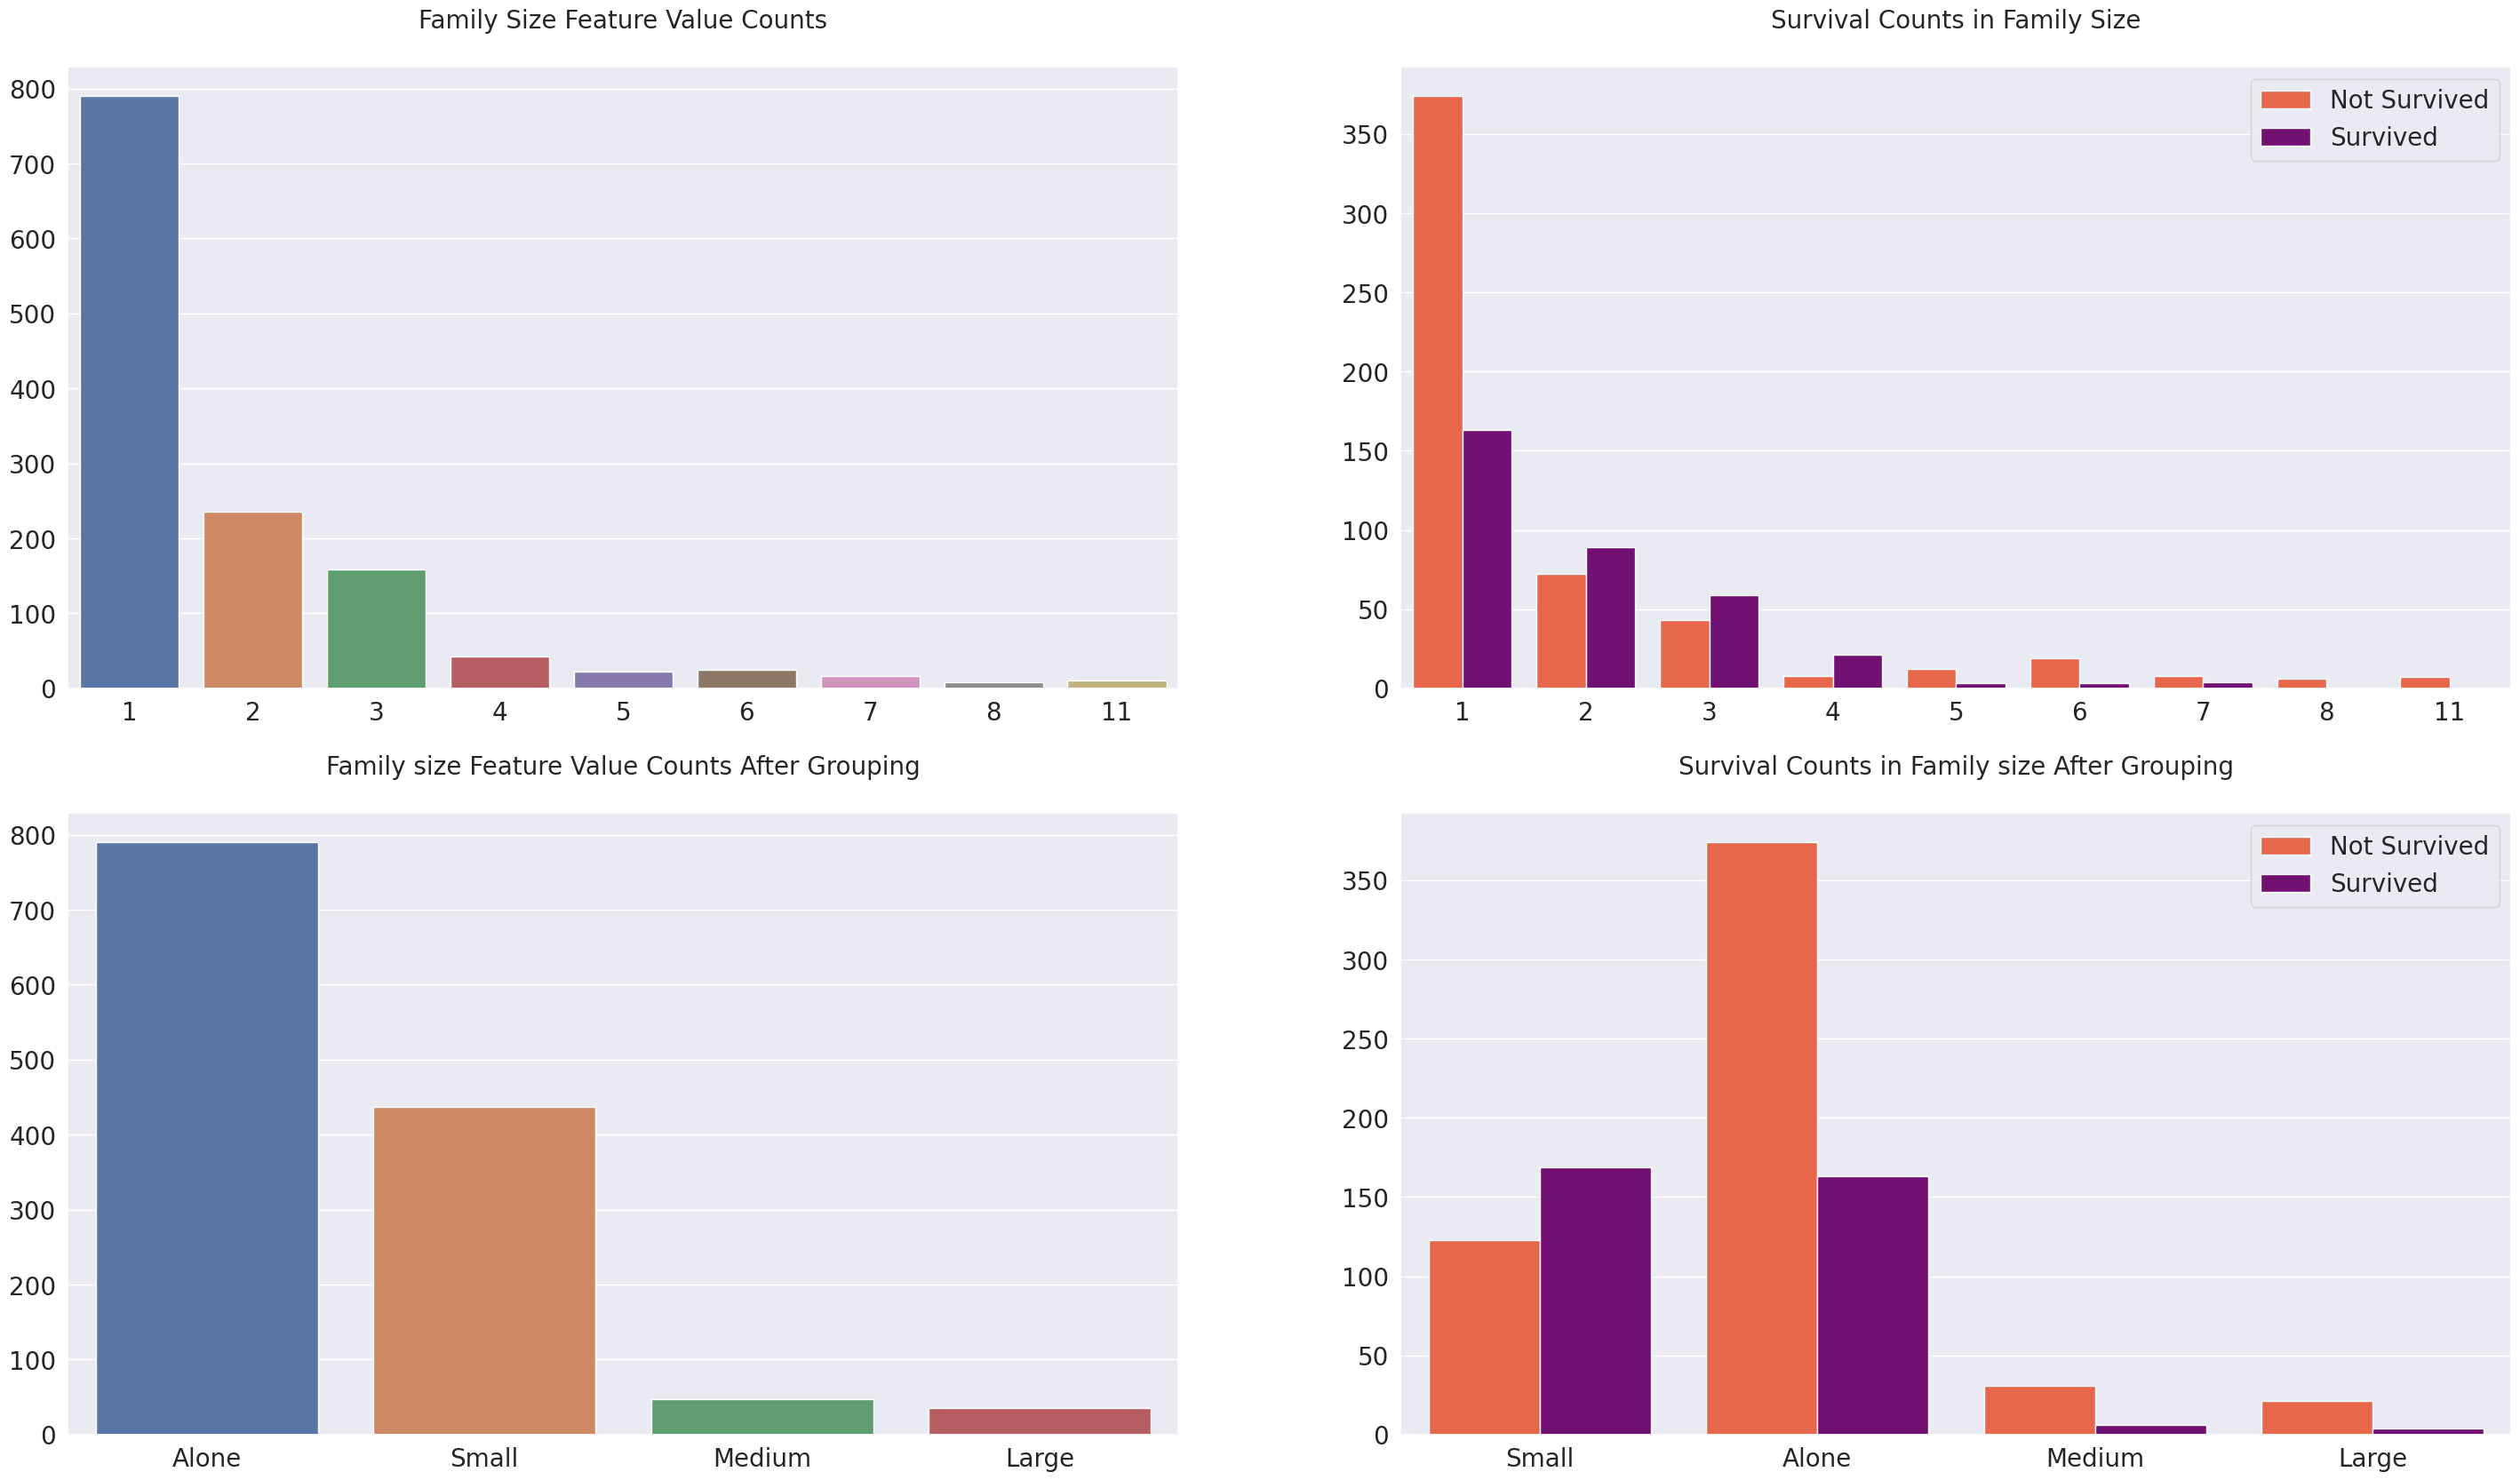

In [31]:
df_all['Family_size'] = df_all['SibSp'] + df_all['Parch'] + 1

fig, axs = plt.subplots(figsize=(20, 20), ncols=2, nrows=2)
plt.subplots_adjust(right=1.5)

sns.barplot(x=df_all['Family_size'].value_counts().index, y=df_all['Family_size'].value_counts().values, ax=axs[0][0])

sns.countplot(x='Family_size', hue='Survived', data=df_all, ax=axs[0][1], palette=['#FF5733', 'purple'])
axs[0][0].set_title('Family Size Feature Value Counts', size=20, y=1.05)
axs[0][1].set_title('Survival Counts in Family Size', size=20, y=1.05)

family_map = {1 : 'Alone', 2: 'Small', 3: 'Small', 4 : 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11:'Large'}
df_all['Family_Group'] = df_all['Family_size'].map(family_map)
sns.barplot(x=df_all['Family_Group'].value_counts().index, y=df_all['Family_Group'].value_counts().values, ax=axs[1][0])
sns.countplot(x='Family_Group', hue='Survived', data=df_all, ax=axs[1][1], palette=['#FF5733', 'purple'])

axs[1][0].set_title('Family size Feature Value Counts After Grouping', size=20, y=1.05)
axs[1][1].set_title('Survival Counts in Family size After Grouping', size=20, y=1.05)

for i in range(2):
    axs[i][1].legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 20})
    for j in range(2):
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
        axs[i][j].set_xlabel('')
        axs[i][j].set_ylabel('')
        
plt.show()

There are too many unique `Ticket` values to analyze, so grouping them up by their frequencies makes things easier.

**How is this feature different than `Family_Size`?** Many passengers travelled along with groups. Those groups consist of friends, nannies, maids and etc. They weren't counted as family, but they used the same ticket.

**Why not grouping tickets by their prefixes?** If prefixes in `Ticket` feature has any meaning, then they are already captured in `Pclass` or `Embarked` features because that could be the only logical information which can be derived from the `Ticket` feature.

According to the graph below, groups with **2**,**3** and **4** members had a higher survival rate. Passengers who travel alone has the lowest survival rate. After **4** group members, survival rate decreases drastically. This pattern is very similar to `Family_Size` feature but there are minor differences. `Ticket_Frequency` values are not grouped like `Family_Size` because that would basically create the same feature with perfect correlation. This kind of feature wouldn't provide any additional information gain.

In [32]:
df_train['Ticket_Frequency'] = df_train.groupby('Ticket')['Ticket'].transform('count')
df_test['Ticket_Frequency'] = df_test.groupby('Ticket')['Ticket'].transform('count')
print(df_train['Ticket_Frequency'])
print(df_test['Ticket_Frequency'])

0      1
1      1
2      1
3      2
4      1
      ..
886    1
887    1
888    2
889    1
890    1
Name: Ticket_Frequency, Length: 891, dtype: int64
891     1
892     1
893     1
894     1
895     1
       ..
1304    1
1305    1
1306    1
1307    1
1308    1
Name: Ticket_Frequency, Length: 418, dtype: int64


In [33]:
df_all['Ticket_Frequency'] = df_all.groupby('Ticket')['Ticket'].transform('count')

### **2.3 Title & Is Married**
`Title` is created by extracting the prefix before `Name` feature. According to graph below, there are many titles that are occuring very few times. Some of those titles doesn't seem correct and they need to be replaced. **Miss**, **Mrs**, **Ms**, **Mlle**, **Lady**, **Mme**, **the Countess**, **Dona** titles are replaced with **Miss/Mrs/Ms** because all of them are female. Values like **Mlle**, **Mme** and **Dona** are actually the name of the passengers, but they are classified as titles because `Name` feature is split by comma. **Dr**, **Col**, **Major**, **Jonkheer**, **Capt**, **Sir**, **Don** and **Rev** titles are replaced with **Dr/Military/Noble/Clergy** because those passengers have similar characteristics. **Master** is a unique title. It is given to male passengers below age **26**. They have the highest survival rate among all males.

`Is_Married` is a binary feature based on the **Mrs** title. **Mrs** title has the highest survival rate among other female titles. This title needs to be a feature because all female titles are grouped with each other.

In [34]:
df_all['Title'] = df_all['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
df_all['Is_Married'] = 0
df_all['Is_Married'].loc[df_all['Title'] == 'Mrs'] = 1

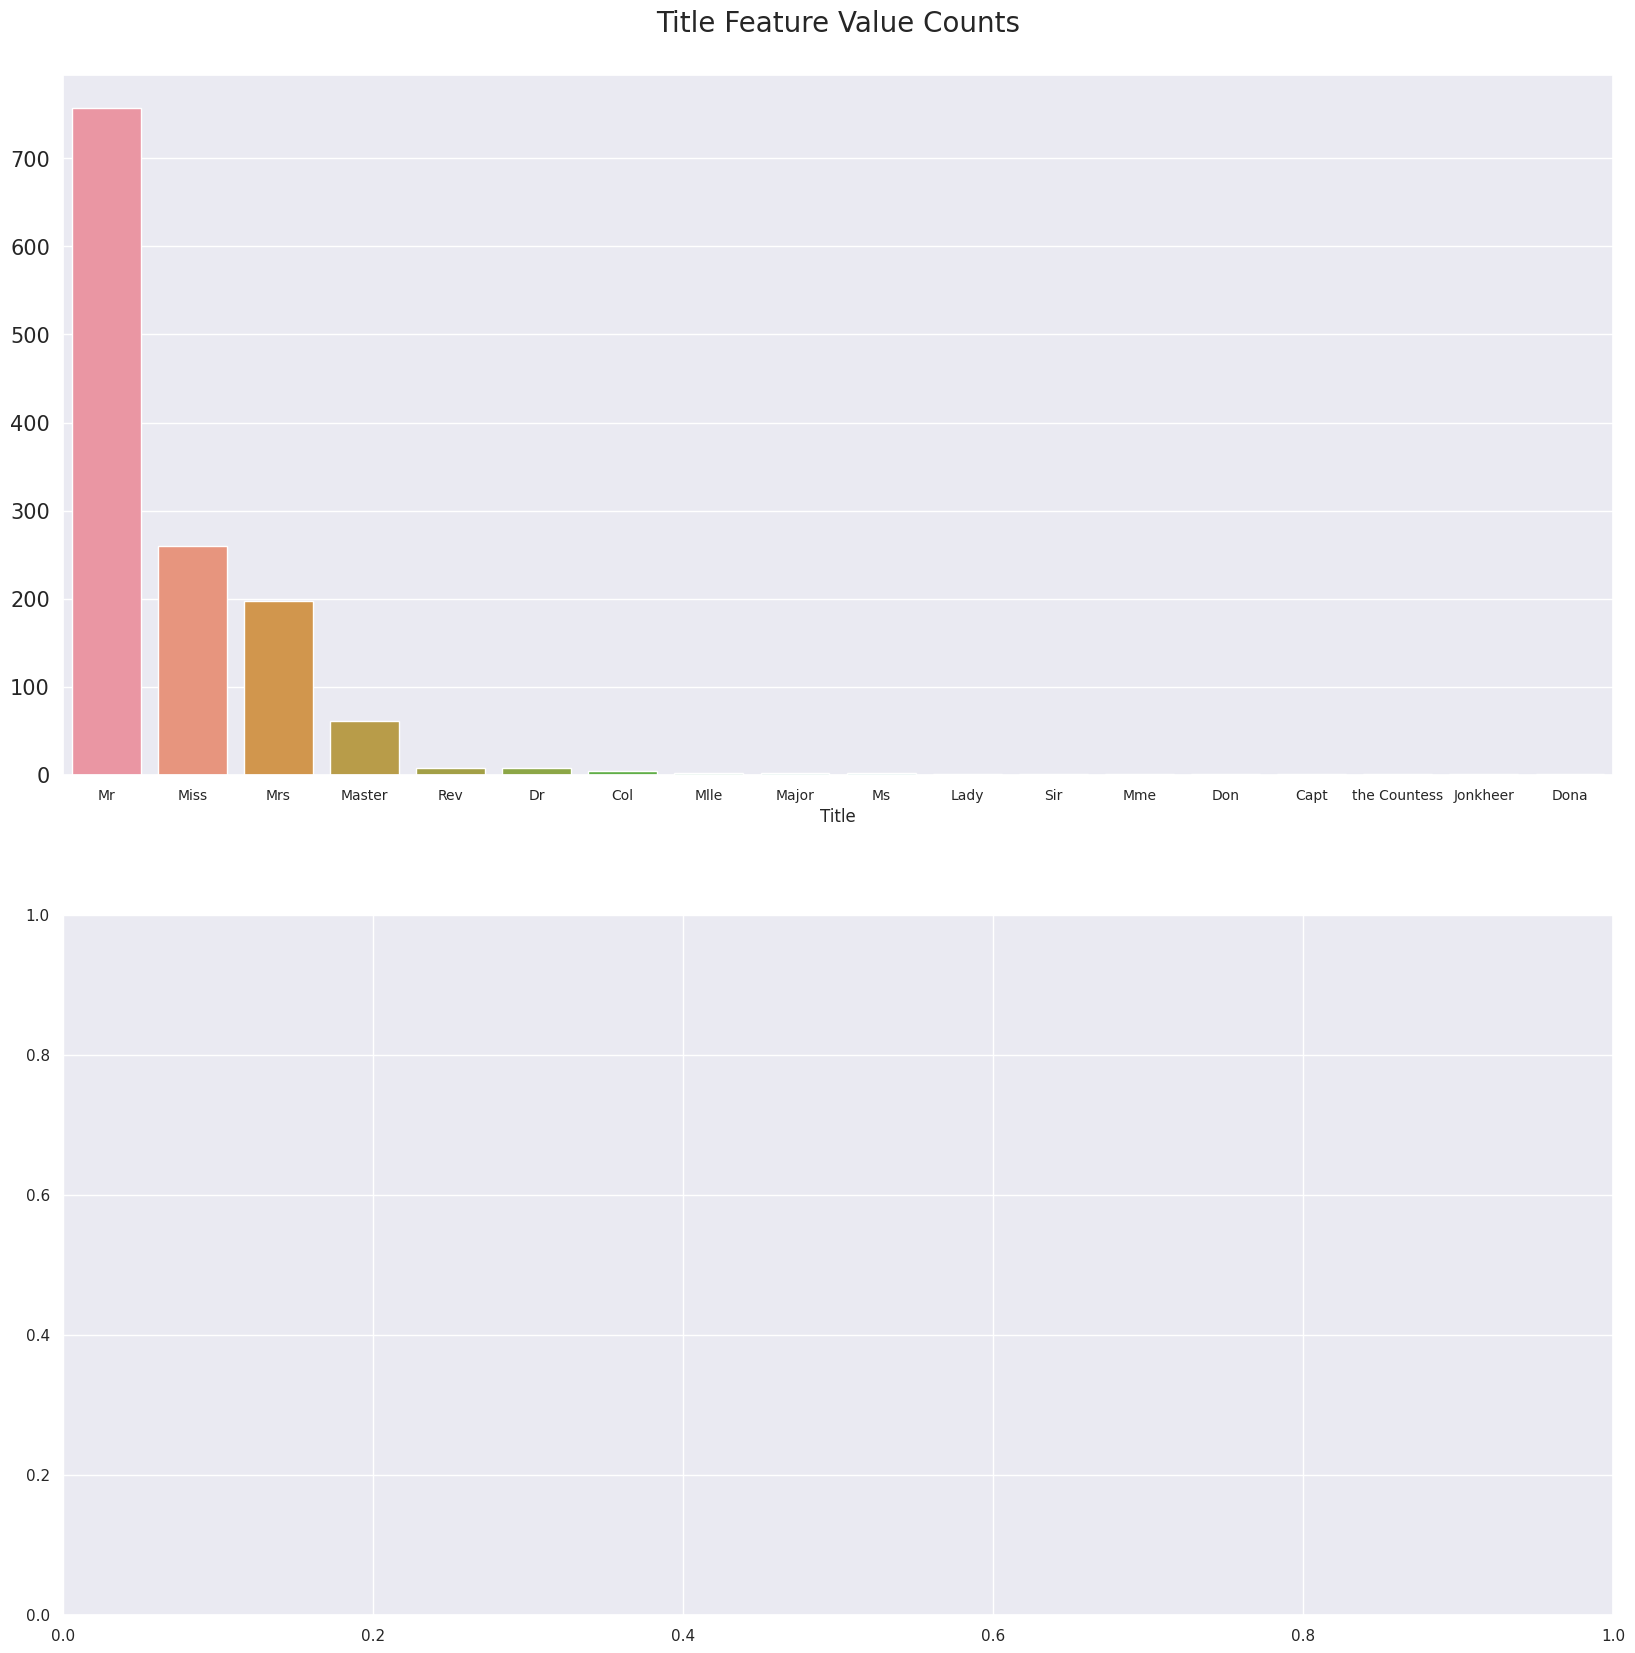

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure and a set of subplots with 2 rows
fig, axs = plt.subplots(nrows=2, figsize=(20, 20))

# Create the first bar plot
sns.barplot(x=df_all['Title'].value_counts().index, y=df_all['Title'].value_counts().values, ax=axs[0])
axs[0].tick_params(axis='x', labelsize=10)  # Set x-axis tick label size
axs[0].tick_params(axis='y', labelsize=15)  # Set y-axis tick label size
axs[0].set_title('Title Feature Value Counts', size=20, y=1.05)  # Set title for the first plot


# Show the plot
plt.show()


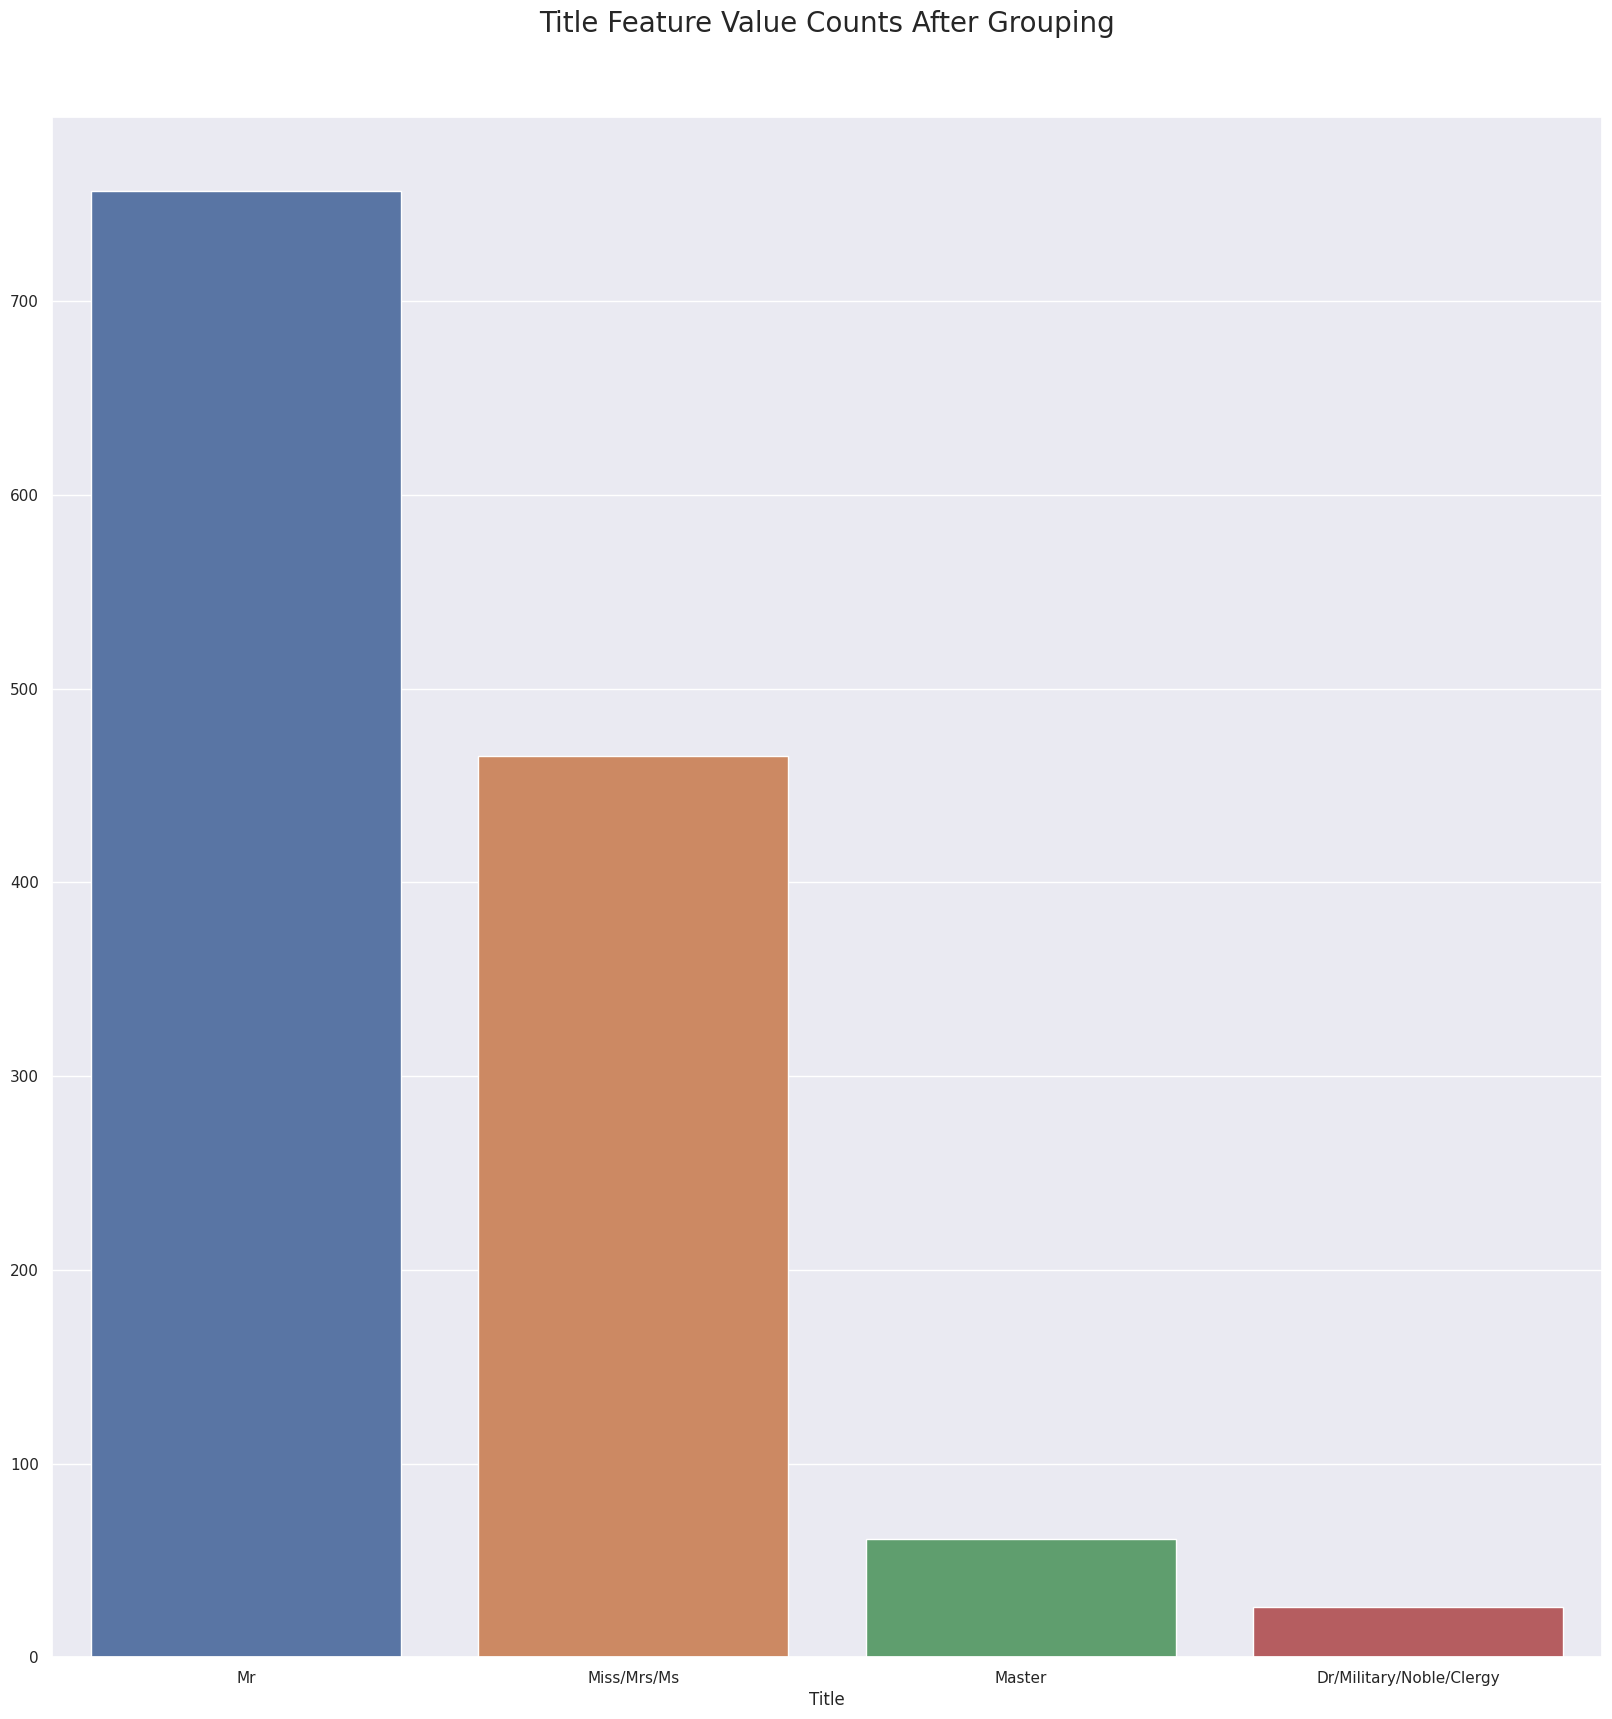

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure and a set of subplots
fig, axs = plt.subplots(figsize=(20, 20))

# Replace specific titles with broader categories
df_all['Title'] = df_all['Title'].replace(['Miss', 'Mrs', 'Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
df_all['Title'] = df_all['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')

# Create a bar plot for the modified 'Title' column
sns.barplot(x=df_all['Title'].value_counts().index, y=df_all['Title'].value_counts().values, ax=axs)
axs.set_title('Title Feature Value Counts After Grouping', size=20, y=1.05)

# Show the plot
plt.show()


### **2.4 Target Encoding**
`extract_surname` function is used for extracting surnames of passengers from the `Name` feature. `Family` feature is created with the extracted surname. This is necessary for grouping passengers in the same family.

In [37]:
def extract_surname(data):    
    
    families = []
    
    for i in range(len(data)):        
        name = data.iloc[i]

        if '(' in name:
            name_no_bracket = name.split('(')[0] 
        else:
            name_no_bracket = name
            
        family = name_no_bracket.split(',')[0]
        title = name_no_bracket.split(',')[1].strip().split(' ')[0]
        
        for c in string.punctuation:
            family = family.replace(c, '').strip()
            
        families.append(family)
            
    return families

df_all['Family'] = extract_surname(df_all['Name'])
df_train = df_all.loc[:890]
df_test = df_all.loc[891:]
dfs = [df_train, df_test]

To compute the survival rate for passengers based on their family or ticket, the following steps are taken:

1. First, a list of family names that appear in both the training and test sets (non_unique_families) is created.

2. For families with more than one member in the list, their survival rate is calculated and stored in the Family_Survival_Rate feature. This is because survival rates can be inferred from family members who share the same family name.

3. An additional binary feature, Family_Survival_Rate_NA, is generated for families unique to the test set. This feature indicates that survival rates cannot be calculated for these families since they lack corresponding data in the training set.

4. Similarly, Ticket_Survival_Rate and Ticket_Survival_Rate_NA features are created using a similar method based on ticket numbers.

5. Survival_Rate is computed by averaging the Ticket_Survival_Rate and Family_Survival_Rate features. This provides an overall survival rate based on both family and ticket information.

6. Likewise, Survival_Rate_NA is calculated by averaging the Ticket_Survival_Rate_NA and Family_Survival_Rate_NA features. This represents an average rate for passengers whose survival rates cannot be determined due to missing data or uniqueness in the test set.



In [38]:
df_all.head()

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Deck,Family_size,Family_Group,Ticket_Frequency,Title,Is_Married,Family
0,"(34.0, 40.0]",2.0,"(-0.001, 7.25]","Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,M,2,Small,1,Mr,0,Braund
1,"(34.0, 40.0]",0.0,"(56.496, 83.475]","Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,ABC,2,Small,2,Miss/Mrs/Ms,1,Cumings
2,"(48.0, 80.0]",2.0,"(7.896, 8.05]","Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,M,1,Alone,1,Miss/Mrs/Ms,0,Heikkinen
3,"(34.0, 40.0]",2.0,"(34.075, 56.496]","Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,ABC,2,Small,2,Miss/Mrs/Ms,1,Futrelle
4,"(48.0, 80.0]",2.0,"(7.896, 8.05]","Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,M,1,Alone,1,Mr,0,Allen


In [39]:
# Creating a list of families and tickets that are occuring in both training and test set
non_unique_families = [x for x in df_train['Family'].unique() if x in df_test['Family'].unique()]
non_unique_tickets = [x for x in df_train['Ticket'].unique() if x in df_test['Ticket'].unique()]

# Assuming you want to calculate the median for 'Survived' and count for 'Family_size' and 'Family'
df_family_survival_rate = df_train.groupby('Family')['Survived'].median().reset_index()
df_family_counts = df_train.groupby('Family')['Family_size'].count().reset_index()

# Merging the survival rates and counts back together if needed
df_family_survival_rate = df_family_survival_rate.merge(df_family_counts, on='Family')

# Similar approach for Ticket, assuming you want median of 'Survived' and count for 'Ticket_Frequency'
df_ticket_survival_rate = df_train.groupby('Ticket')['Survived'].median().reset_index()
df_ticket_counts = df_train.groupby('Ticket')['Ticket_Frequency'].count().reset_index()

# Merging the survival rates and counts for tickets
df_ticket_survival_rate = df_ticket_survival_rate.merge(df_ticket_counts, on='Ticket')

# Note: Adjust 'Family_size', 'Family', 'Ticket', and 'Ticket_Frequency' calculations as needed
# The .count().reset_index() is an example of how you might handle counting occurrences or other aggregate functions

family_rates = {}
ticket_rates = {}

for i in range(len(df_family_survival_rate)):
    # Checking a family exists in both training and test set, and has members more than 1
    if df_family_survival_rate.index[i] in non_unique_families and df_family_survival_rate.iloc[i, 1] > 1:
        family_rates[df_family_survival_rate.index[i]] = df_family_survival_rate.iloc[i, 0]

for i in range(len(df_ticket_survival_rate)):
    # Checking a ticket exists in both training and test set, and has members more than 1
    if df_ticket_survival_rate.index[i] in non_unique_tickets and df_ticket_survival_rate.iloc[i, 1] > 1:
        ticket_rates[df_ticket_survival_rate.index[i]] = df_ticket_survival_rate.iloc[i, 0]

In [40]:
mean_survival_rate = np.mean(df_train['Survived'])

train_family_SR = []
train_family_SR_NA = []
test_family_SR = []
test_family_SR_NA = []

# Processing training data
for i, family in enumerate(df_train['Family']):
    if family in family_rates:
        train_family_SR.append(family_rates[family])
        train_family_SR_NA.append(1)
    else:
        train_family_SR.append(mean_survival_rate)
        train_family_SR_NA.append(0)

# Processing test data
for i, family in enumerate(df_test['Family']):
    if family in family_rates:
        test_family_SR.append(family_rates[family])
        test_family_SR_NA.append(1)
    else:
        test_family_SR.append(mean_survival_rate)
        test_family_SR_NA.append(0)

# Assigning values to DataFrame columns
df_train['Family_Survival_Rate'] = train_family_SR
df_train['Family_Survival_Rate_NA'] = train_family_SR_NA
df_test['Family_Survival_Rate'] = test_family_SR
df_test['Family_Survival_Rate_NA'] = test_family_SR_NA


In [41]:
mean_survival_rate = np.mean(df_train['Survived'])

train_ticket_SR = []
train_ticket_SR_NA = []
test_ticket_SR = []
test_ticket_SR_NA = []

# Processing training data
for i in range(len(df_train)):
    if df_train['Ticket'][i] in ticket_rates:
        train_ticket_SR.append(ticket_rates[df_train['Ticket'][i]])
        train_ticket_SR_NA.append(1)
    else:
        train_ticket_SR.append(mean_survival_rate)
        train_ticket_SR_NA.append(0)

# Processing test data
for i in range(len(df_test)):
    if df_test['Ticket'].iloc[i] in ticket_rates:
        test_ticket_SR.append(ticket_rates[df_test['Ticket'].iloc[i]])
        test_ticket_SR_NA.append(1)
    else:
        test_ticket_SR.append(mean_survival_rate)
        test_ticket_SR_NA.append(0)

# Assigning values to DataFrame columns
df_train['Ticket_Survival_Rate'] = train_ticket_SR
df_train['Ticket_Survival_Rate_NA'] = train_ticket_SR_NA
df_test['Ticket_Survival_Rate'] = test_ticket_SR
df_test['Ticket_Survival_Rate_NA'] = test_ticket_SR_NA


In [42]:
for df in [df_train, df_test]:
    df['Survival_Rate'] = (df['Ticket_Survival_Rate'] + df['Family_Survival_Rate']) / 2
    df['Survival_Rate_NA'] = (df['Ticket_Survival_Rate_NA'] + df['Family_Survival_Rate_NA']) / 2

### **2.5 Feature Transformation**

#### **2.5.1 Label Encoding Non-Numerical Features**
`Embarked`, `Sex`, `Deck` , `Title` and `Family_Size_Grouped` are object type, and `Age` and `Fare` features are category type. They are converted to numerical type with `LabelEncoder`. `LabelEncoder` basically labels the classes from **0** to **n**. This process is necessary for models to learn from those features.

In [43]:
from sklearn.preprocessing import LabelEncoder

# Define the non-numeric features that you wish to encode
non_numeric_features = ['Embarked', 'Sex', 'Deck', 'Title', 'Family_Group', 'Age', 'Fare']

# Assuming `dfs` is a list of your DataFrames
for df in dfs:  # Assuming 'dfs' is your list of DataFrames
    for feature in non_numeric_features:  # Your list of features to process
        if pd.api.types.is_categorical_dtype(df[feature]):
            # Add 'missing' to categories
            df[feature] = df[feature].cat.add_categories(['missing'])
        # Now you can safely fill missing values with 'missing'
        df[feature] = df[feature].fillna('missing').astype(str)
        
        # After filling missing values, you can proceed with LabelEncoder or any other processing
        df[feature] = LabelEncoder().fit_transform(df[feature])


#### **2.5.2 One-Hot Encoding the Categorical Features**
The categorical features (`Pclass`, `Sex`, `Deck`, `Embarked`, `Title`) are converted to one-hot encoded features with `OneHotEncoder`. `Age` and `Fare` features are not converted because they are ordinal unlike the previous ones.

In [44]:
cat_features = ['Pclass', 'Sex', 'Deck', 'Embarked', 'Title', 'Family_Group']
encoded_features = []

for df in dfs:
    for feature in cat_features:
        encoded_feat = OneHotEncoder().fit_transform(df[feature].values.reshape(-1, 1)).toarray()
        n = df[feature].nunique()
        cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
        encoded_df = pd.DataFrame(encoded_feat, columns=cols)
        encoded_df.index = df.index
        encoded_features.append(encoded_df)

df_train = pd.concat([df_train, *encoded_features[:6]], axis=1)
df_test = pd.concat([df_test, *encoded_features[6:]], axis=1)

In [45]:
df_all.columns

Index(['Age', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId', 'Pclass',
       'Sex', 'SibSp', 'Survived', 'Ticket', 'Deck', 'Family_size',
       'Family_Group', 'Ticket_Frequency', 'Title', 'Is_Married', 'Family'],
      dtype='object')

In [46]:
import pandas as pd

def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set
    return pd.concat([train_data, test_data], ignore_index=True)

# Concatenate df_train and df_test
df_all = concat_df(df_train, df_test)

# List of columns you intend to drop from the concatenated DataFrame
drop_cols = ['Deck', 'Embarked', 'Embarked_4', 'Family', 'Family_size', 'Family_Group', 'Survived',
             'Name', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Ticket', 'Title',
             'Ticket_Survival_Rate', 'Family_Survival_Rate', 'Ticket_Survival_Rate_NA', 'Family_Survival_Rate_NA']
# List of columns you intend to drop from the concatenated DataFrame
drop_columns = ['Deck', 'Embarked', 'Family', 'Family_size', 'Family_Group', 'Survived',
             'Name', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Ticket', 'Title',
             'Ticket_Survival_Rate', 'Family_Survival_Rate', 'Ticket_Survival_Rate_NA', 'Family_Survival_Rate_NA']
# Dropping the specified columns
df_all.drop(columns=drop_cols, inplace=True)

# Print the first few rows to verify the transformations
print(df_all.head())


   Age  Fare  Ticket_Frequency  Is_Married  Survival_Rate  Survival_Rate_NA  \
0    7     0                 1           0       0.383838               0.0   
1    7     7                 2           1       0.383838               0.0   
2    9    10                 1           0       0.383838               0.0   
3    7     6                 2           1       0.383838               0.0   
4    9    10                 1           0       0.383838               0.0   

   Pclass_1  Pclass_2  Pclass_3  Sex_1  ...  Embarked_2  Embarked_3  Title_1  \
0       0.0       0.0       1.0    0.0  ...         0.0         1.0      0.0   
1       1.0       0.0       0.0    1.0  ...         0.0         0.0      0.0   
2       0.0       0.0       1.0    1.0  ...         0.0         1.0      0.0   
3       1.0       0.0       0.0    1.0  ...         0.0         1.0      0.0   
4       0.0       0.0       1.0    0.0  ...         0.0         1.0      0.0   

   Title_2  Title_3  Title_4  Family_Group_1

### **2.6 Conclusion**
`Age` and `Fare` features are binned. Binning helped dealing with outliers and it revealed some homogeneous groups in those features. `Family_Size` is created by adding `Parch` and `SibSp` features and **1**. `Ticket_Frequency` is created by counting the occurence of `Ticket` values.

`Name` feature is very useful. First, `Title` and `Is_Married` features are created from the title prefix in the names. Second, `Family_Survival_Rate` and `Family_Survival_Rate_NA`  features are created by target encoding the surname of the passengers. `Ticket_Survival_Rate` is created by target encoding the `Ticket` feature. `Survival_Rate` feature is created by averaging the `Family_Survival_Rate` and `Ticket_Survival_Rate` features.

Finally, the non-numeric type features are label encoded and categorical features are one-hot encoded. Created **5** new features (`Family_Size`, `Title`, `Is_Married`, `Survival_Rate` and `Survival_Rate_NA`) and dropped the useless features after encoding.

In [47]:
df_all.head()

,Age,Fare,Ticket_Frequency,Is_Married,Survival_Rate,Survival_Rate_NA,Pclass_1,Pclass_2,Pclass_3,Sex_1,...,Embarked_2,Embarked_3,Title_1,Title_2,Title_3,Title_4,Family_Group_1,Family_Group_2,Family_Group_3,Family_Group_4
0,7,0,1,0,0.383838,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,7,7,2,1,0.383838,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,9,10,1,0,0.383838,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,7,6,2,1,0.383838,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,9,10,1,0,0.383838,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


# **3. Model**

# # RandomForestClassifier

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

interval_columns = [col for col in df_train.columns if pd.api.types.is_interval_dtype(df_train[col])]

# Convert Interval columns to midpoints (or another representative value)
for col in interval_columns:
    df_train[col] = df_train[col].apply(lambda x: x.mid if pd.notnull(x) else x)

# Now, assuming 'drop_cols' are the columns you want to exclude before scaling
X_train = StandardScaler().fit_transform(df_train.drop(columns=drop_cols))
y_train = df_train['Survived'].values
X_test = StandardScaler().fit_transform(df_test.drop(columns=drop_columns))

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))




X_train shape: (891, 26)
y_train shape: (891,)
X_test shape: (418, 26)


In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Assuming df_train, df_test, drop_cols, and target_train are defined and preprocessed

# Convert Interval columns to midpoints (or another representative value)
interval_columns = [col for col in df_train.columns if pd.api.types.is_interval_dtype(df_train[col])]
for col in interval_columns:
    df_train[col] = df_train[col].apply(lambda x: x.mid if pd.notnull(x) else x)

# Now, assuming 'drop_cols' are the columns you want to exclude before scaling
X_train = df_train.drop(columns=drop_cols)
y = df_train['Survived']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler instance
# Make sure to drop only the columns that exist in the test data
X_test_scaled = scaler.transform(df_test.drop(columns=[col for col in drop_cols if col in df_test.columns]))

# Initialize the RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the RandomForestClassifier
rf_classifier.fit(X_train_scaled, y)

# Predict on the test data
y_pred = rf_classifier.predict(X_test_scaled)


output = pd.DataFrame({'PassengerId': df_test.PassengerId, 'Survived': y_pred.astype(int)})

output.to_csv('submission.csv', index=False)
print(output)
print("Your submission was successfully saved!")



      PassengerId  Survived
891           892         0
892           893         1
893           894         0
894           895         0
895           896         0
...           ...       ...
1304         1305         0
1305         1306         1
1306         1307         0
1307         1308         0
1308         1309         1

[418 rows x 2 columns]
Your submission was successfully saved!
